#### Libraries and Data

In [1]:
import pandas as pd
import numpy as np
import datetime
import pymannkendall as mk
import matplotlib.pyplot as plt
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_excel("2021.05.12_Chesapeake Bay Program Water Monitoring Station Data.xlsx")

In [3]:
thresholds = pd.read_excel('Stations.xlsx', sheet_name='Thresholds')

#### Sorting

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38894 entries, 0 to 38893
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   MonitoringStation    38894 non-null  object        
 1   EventId              38894 non-null  int64         
 2   Cruise               38894 non-null  object        
 3   Program              38894 non-null  object        
 4   Project              38894 non-null  object        
 5   Agency               38894 non-null  object        
 6   Source               38894 non-null  object        
 7   Station              38894 non-null  object        
 8   SampleDate           38894 non-null  datetime64[ns]
 9   SampleTime           38894 non-null  object        
 10  TotalDepth           37965 non-null  float64       
 11  UpperPycnocline      0 non-null      float64       
 12  LowerPycnocline      0 non-null      float64       
 13  Depth                38894 non-

Important columns:
- Station - location ID
- SampleDate - date sampled
- SampleTime - time sampled
- Depth - distance from the surface sample was taken
- SampleType - type of sample (Discrete, Composite, or In-Situ)
- SampleReplicateType - laboratory replicate or field duplicate
- Parameter - parameter being measured
- MeasureValue - resulting concentration
- Qualifier - above or below detection limit
- Unit - unit of measurment
- Problem - identifies any analytical problems, if any
- Lat/Long - coordinates for the location

In [5]:
#keeping just columns of interest for now
cols = ['Station', 'SampleDate', 'SampleTime', 'Depth', 'SampleType', 'SampleReplicateType',
       'Parameter', 'MeasureValue', 'Qualifier', 'Unit', 'Problem']

df = data[cols]
df.head()

Station SampleDate SampleTime  Depth SampleType SampleReplicateType  \
0  BXK0031 2003-03-12   09:08:00    0.0          D                  S1   
1  BXK0031 2003-04-14   08:50:00    0.0          D                  S1   
2  BXK0031 2003-07-09   08:50:00    0.0          D                  S1   
3  BXK0031 2003-08-06   08:48:00    0.0          D                  S1   
4  BXK0031 2003-05-07   09:15:00    0.0          D                  S1   

  Parameter  MeasureValue Qualifier  Unit Problem  
0      CHLA        154.19       NaN  UG/L     NaN  
1      CHLA          1.50       NaN  UG/L     NaN  
2      CHLA          5.98       NaN  UG/L     NaN  
3      CHLA         36.88       NaN  UG/L     NaN  
4      CHLA          8.37       NaN  UG/L     NaN

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38894 entries, 0 to 38893
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Station              38894 non-null  object        
 1   SampleDate           38894 non-null  datetime64[ns]
 2   SampleTime           38894 non-null  object        
 3   Depth                38894 non-null  float64       
 4   SampleType           38894 non-null  object        
 5   SampleReplicateType  38894 non-null  object        
 6   Parameter            38894 non-null  object        
 7   MeasureValue         38774 non-null  float64       
 8   Qualifier            1043 non-null   object        
 9   Unit                 38894 non-null  object        
 10  Problem              392 non-null    object        
dtypes: datetime64[ns](1), float64(2), object(8)
memory usage: 3.3+ MB


In [7]:
print(df.SampleReplicateType.value_counts())
print('\n')
print(df.SampleType.value_counts())
print('\n')
print(df.Parameter.value_counts())
print('\n')
print(df.Problem.value_counts())

S1     20442
M1     15251
FS1     1603
FS2     1598
Name: SampleReplicateType, dtype: int64


D      23643
ISM    15251
Name: SampleType, dtype: int64


DO      15251
NO3F     6185
CHLA     5967
TP       5748
TN       5743
Name: Parameter, dtype: int64


JJ    109
V     107
QQ     92
WW     44
NV     19
A      13
FF      4
U       2
SS      1
X       1
Name: Problem, dtype: int64


#### Notes for future tasks
- DO would have to take depth into consideration (higher DO at surface than at bottom:wind), also from where algae are cycle (and diurnal)
- could use same parameters for NO3F that I used for TN, TP, and CHLA

In [8]:
coords = data[['Station', 'Latitude', 'Longitude']].drop_duplicates()

## Data Setup

Source for methodology: [EIP's "Poultry's Phosphorus Problem" report](https://environmentalintegrity.org/wp-content/uploads/2016/11/2014-07_Poultrys_Phosphorus_Problem.pdf)

Source for data glossary: [Guide to Using Chesapeak Bay Program Water Quality Monitoring Data](https://www.chesapeakebay.net/documents/3676/wq_data_userguide_10feb12_mod.pdf)

1. Need to take seasonal averages for total phosphorus, total nitrogen, and chlorophyll-a.
    - For both phosphorus and nitrogen, we want to look at samples collected from Spring, Summer, Winter, and Fall.
    - For chlorophyll-a, we will break it up into spring (March-May) and summer (July through September) seasonal averages. June is excluded when looking at chlorophyll-a because "June is considered a highly variable month for chlorophyll-a, and the benchmark values do not apply during June" (taken from a footnote in our 2014 report).
2. Looking at data from 2003 to 2020, so we'll need to filter anything outside of that range.

#### Cleaning Tasks
We first need to filter our data down to just the parameters we want to focus on: **TP** (total phosphorus), **TN** (total nitrogen), and **CHLA** (chlorophyll-a).

In [9]:
#filter ton only parameters of desire
params = df[df['Parameter'].isin(['TN', 'TP', 'CHLA'])]

In [10]:
#checking for problems in data
params['Problem'].value_counts()

JJ    109
V     107
WW     44
QQ     29
A      12
FF      4
U       2
X       1
Name: Problem, dtype: int64

Based on the provided [data dictionary](https://www.chesapeakebay.net/documents/3676/cbwqdb2004_rb.pdf), we removed measurements with the following problem codes:
1. V - "Sample results rejected due to QC criteria"
2. A - "Laboratory accident"
3. X - "Sample not preserved properly"

All other problem codes were kept.

In [11]:
#dataframe with problems removed
problems = params[params['Problem'].isin(['V ', 'A ', 'X ']) == False]

In [12]:
#checking for results with qualifiers
problems[problems['Qualifier'].notnull()].head()

Station SampleDate SampleTime  Depth SampleType SampleReplicateType  \
1596   ET10.1 2013-10-16   11:54:00    6.2          D                  S1   
6516   ET10.1 2016-01-11   13:14:00    6.6          D                  S1   
6517   ET10.1 2016-01-11   13:14:00    0.5          D                  S1   
7982   ET10.1 2016-05-11   11:50:00    0.5          D                  S1   
10642  ET10.1 2016-12-14   12:10:00    5.7          D                  S1   

      Parameter  MeasureValue Qualifier  Unit Problem  
1596       CHLA          0.27         <  UG/L      JJ  
6516       CHLA          0.62         <  UG/L     NaN  
6517       CHLA          0.62         <  UG/L     NaN  
7982       CHLA          0.62         <  UG/L     NaN  
10642      CHLA          0.62         <  UG/L     NaN

We will go ahead and just use the detection limit (`0.27` or `0.62`) when averaging duplicates and reporting on trends.

#### Checking for duplicates

In [13]:
print(problems.SampleReplicateType.value_counts())

S1     14929
FS2     1206
FS1     1203
Name: SampleReplicateType, dtype: int64


In [14]:
#checking for presence of duplicates
dup_check = problems[['Station', 'SampleDate', 'Parameter']]
dup_check[dup_check.duplicated()]

Station SampleDate Parameter
131      ET6.2 2015-01-05      CHLA
139      ET6.2 2015-01-05        TN
141      ET6.2 2015-01-05        TP
143      ET8.1 2015-01-05      CHLA
424      ET8.1 2015-01-05        TN
...        ...        ...       ...
38633  XAK7810 2006-10-18        TN
38635  XAK7810 2006-10-18        TP
38637  XAK7810 2006-11-14      CHLA
38639  XAK7810 2006-11-14        TN
38641  XAK7810 2006-11-14        TP

[6813 rows x 3 columns]

In [15]:
problems[problems['Station'] == 'ET6.2']

Station SampleDate SampleTime  Depth SampleType SampleReplicateType  \
130     ET6.2 2015-01-05   11:03:00    3.0          D                  S1   
131     ET6.2 2015-01-05   11:03:00    0.5          D                  S1   
138     ET6.2 2015-01-05   11:03:00    0.5          D                  S1   
139     ET6.2 2015-01-05   11:03:00    3.0          D                  S1   
140     ET6.2 2015-01-05   11:03:00    3.0          D                  S1   
...       ...        ...        ...    ...        ...                 ...   
37669   ET6.2 2020-12-21   11:28:00    0.5          D                  S1   
37826   ET6.2 2020-12-21   11:28:00    3.3          D                  S1   
37827   ET6.2 2020-12-21   11:28:00    0.5          D                  S1   
37828   ET6.2 2020-12-21   11:28:00    0.5          D                  S1   
37829   ET6.2 2020-12-21   11:28:00    3.3          D                  S1   

      Parameter  MeasureValue Qualifier  Unit Problem  
130        CHLA        5.3400       NaN  UG/L     NaN  
131        CHLA        6.0500       NaN  UG/L     NaN  
138          TN        1.4540       NaN  MG/L     NaN  
139          TN        1.4690       NaN  MG/L     NaN  
140          TP        0.0374       NaN  MG/L     NaN  
...         ...           ...       ...   ...     ...  
37669      CHLA        3.5600       NaN  UG/L     NaN  
37826        TN        2.1580       NaN  MG/L     NaN  
37827        TN        3.0120       NaN  MG/L     NaN  
37828        TP        0.0677       NaN  MG/L     NaN  
37829        TP        0.0444       NaN  MG/L     NaN  

[1491 rows x 11 columns]

Looks like there are duplicate measurements per monitoring location based on the depth of measurement, so we'll go ahead and just average the duplicate concentrations for each parameter by station and sample date.

In [16]:
#removing depth
filtered = problems.drop(columns=['Depth'])
#averaging duplicates based on station, sample date, and parameter
dedup = filtered.groupby(['Station', 'SampleDate', 'Parameter', 'Unit'], as_index=False).mean()

#### Checking for correct timeframe

In [17]:
print(dedup.SampleDate.min())

2000-01-17 00:00:00


In [18]:
#creating year and month columns
dedup['Year'] = pd.DatetimeIndex(dedup['SampleDate']).year
dedup['Month'] = pd.DatetimeIndex(dedup['SampleDate']).month

#need to remove data that came before 2003
d_range = dedup[dedup.Year > 2002]

Changing filter system here to allow for more exploration. The seasons are off a little bit when comparing chlorophyll-a to either nitrogen or phosphorus because June measurements are not used when looking at chlorophyll-a, as it's a highly variable month.

Since chlorophyll-a isn't a concern during fall and winter months, and there are [no relevant seasonal benchmarks](https://ecoreportcard.org/report-cards/chesapeake-bay/indicators/chlorophyll-a/) to compare to during those months for chlorophyll-a, I've removed those samples from the analysis.

In [19]:
#creating column that sorts for seasons
conditions = [
    (d_range['Parameter'] == 'CHLA') & (d_range['Month'].isin([3,4,5])),
    (d_range['Parameter'] == 'CHLA') & (d_range['Month'].isin([7,8,9])),
    (d_range['Parameter'] == 'CHLA') & (d_range['Month'].isin([6,10,11,12,1,2])),
    (d_range['Parameter'] != 'CHLA') & (d_range['Month'].isin([12,1,2])),
    (d_range['Parameter'] != 'CHLA') & (d_range['Month'].isin([9,10,11])),
    (d_range['Parameter'] != 'CHLA') & (d_range['Month'].isin([6,7,8])),
    (d_range['Parameter'] != 'CHLA') & (d_range['Month'].isin([3,4,5]))
]

values = ['Spring', 'Summer', 'Other', 'Winter', 'Fall', 'Summer', 'Spring']

d_range['Season'] = np.select(conditions, values)

#sorting out values not in the seasons we care about
sort = d_range[d_range['Season'] != 'Other']
sort = sort.sort_values('SampleDate', ascending = True)

#### Name changes and merging thresholds

In [20]:
#changing parameter names for readability and to merge with the threholds
conditions_2 = [
    (sort['Parameter'] == 'CHLA') & (sort['Season'] == 'Spring'),
    (sort['Parameter'] == 'CHLA') & (sort['Season'] == 'Summer'),
    (sort['Parameter'] == 'TP'),
    (sort['Parameter'] == 'TN')
]

new_names = ['Chlorophyll-a, Spring', 'Chlorophyll-a, Summer', 'Total Phosphorus', 'Total Nitrogen']

sort['Parameter_new'] = np.select(conditions_2, new_names)

sort.drop(columns=['Parameter'], inplace=True)
sort.rename(columns={'Parameter_new': 'Parameter'}, inplace=True)

#merging with threshold data
final = pd.merge(sort, thresholds, how='left', on=['Station', 'Parameter'])

In [21]:
#writing to Excel
final[['Station','SampleDate','Year','Parameter', 'Season', 'Unit','MeasureValue','Threshold']].to_excel("01_Monitoring Data_cleaned.xlsx",index=False)

## Exploration

### Initial Visualizations

In [22]:
#creating a function that visualizes the concentrations over time for each iteration of monitor and parameter
def scatters(df):
    """Takes in a whole dataframe of monitoring data and returns a scatter plot of test results
    for each iteration of monitor and parameter."""
    
    stations = list(df.Station.unique())
    
    plots = []
    
    for station in stations:
        temp_1 = df[df['Station'] == station]
        params = list(temp_1.Parameter.unique())
        
        for param in params:
            temp_2 = temp_1[temp_1['Parameter'] == param]
            fig = plt.figure(figsize=(8,5))
            threshold = round(list(temp_2['Threshold'])[0],2)
            unit = list(temp_2['Unit'])[0].lower()
            plt.scatter(x=temp_2['SampleDate'], y=temp_2['MeasureValue'], label = 'Results')
            plt.axhline(y= threshold, color = 'orange', linestyle = 'dashed', label = 'Benchmark ({} ({}))'.format(threshold,unit))
            plt.xlabel('Sample Date')
            plt.ylabel('Results ({})'.format(list(temp_2['Unit'].unique())[0]))
            plt.title('Monitoring Data for {} at {}'.format(param, station))
            plt.legend(loc='upper right')
            plots.append(fig)
    
    return plots

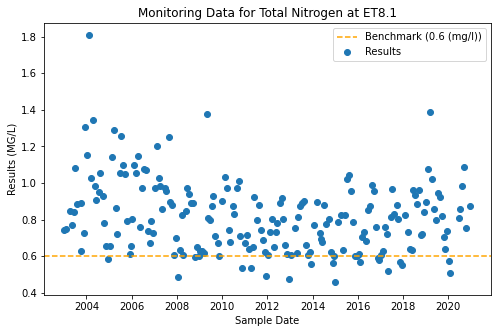

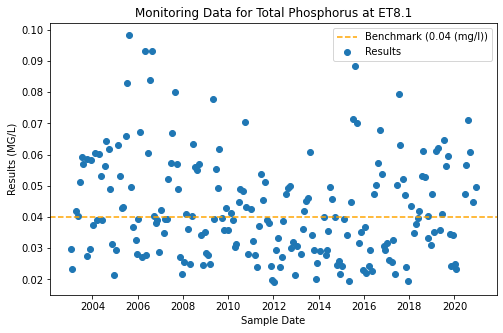

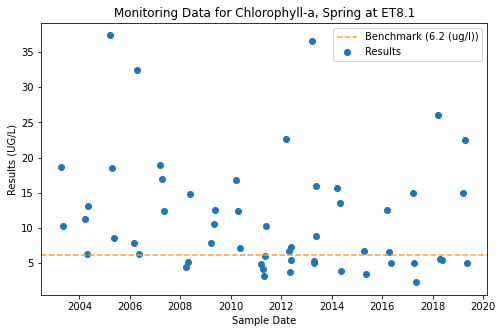

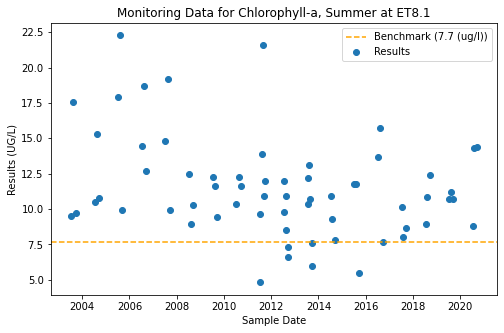

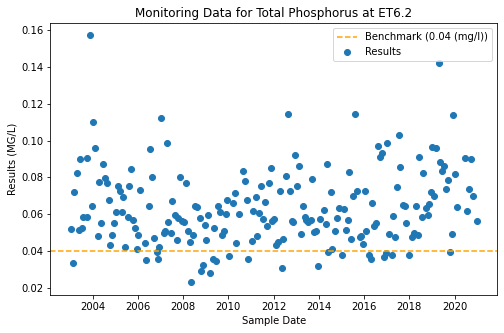

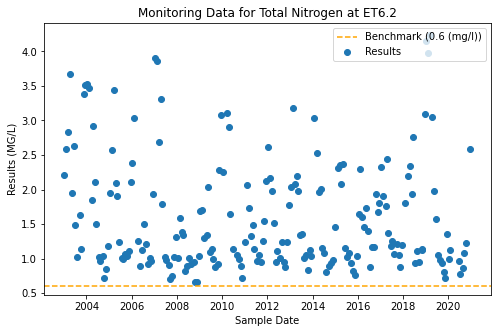

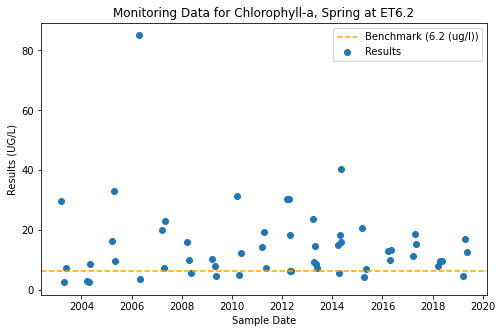

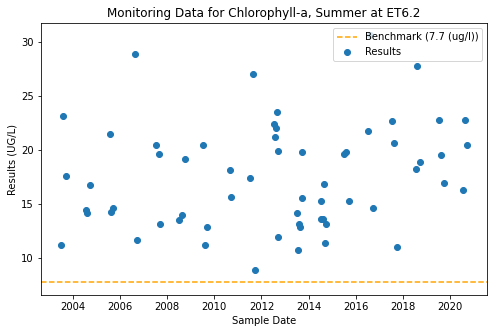

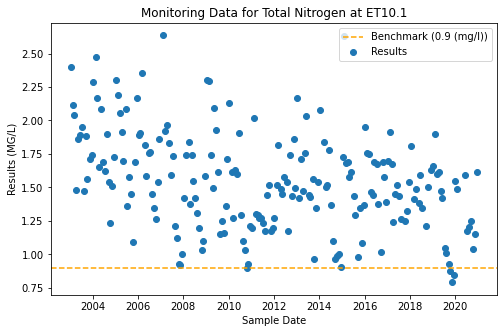

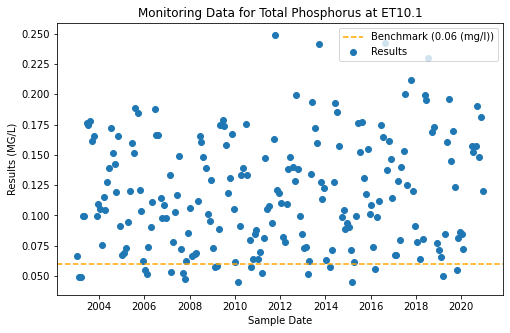

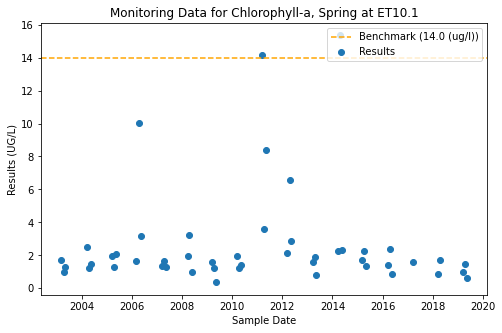

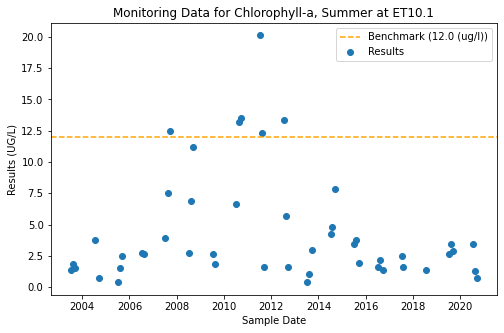

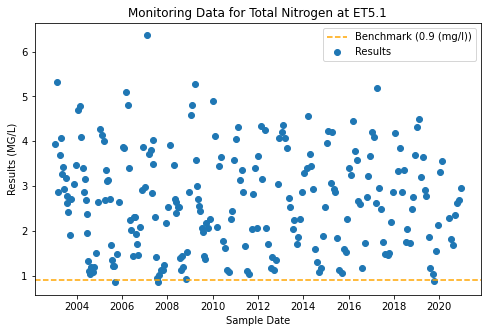

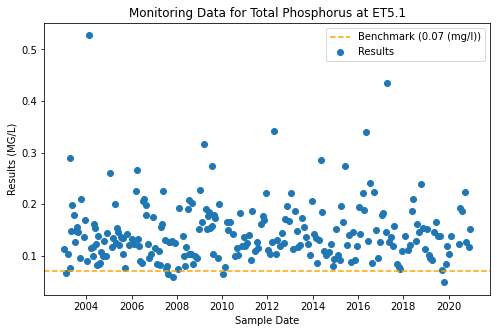

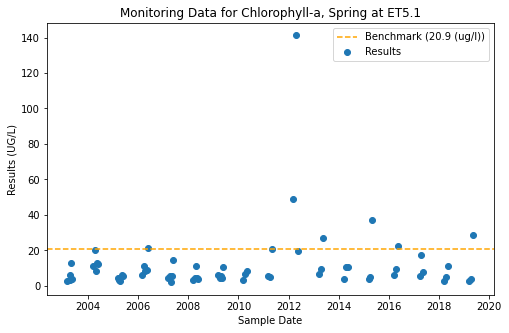

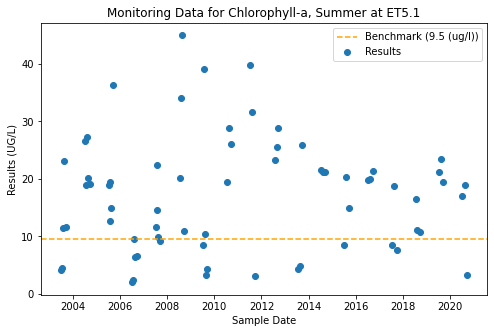

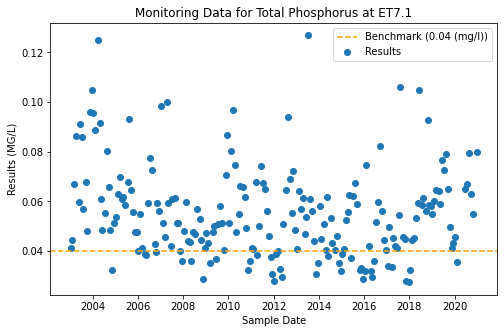

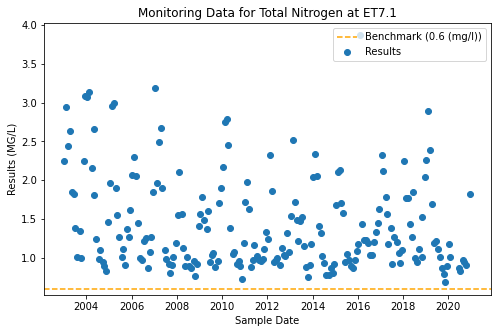

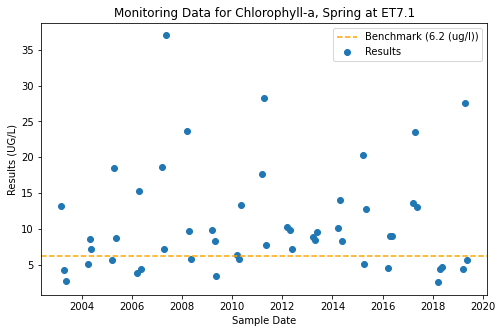

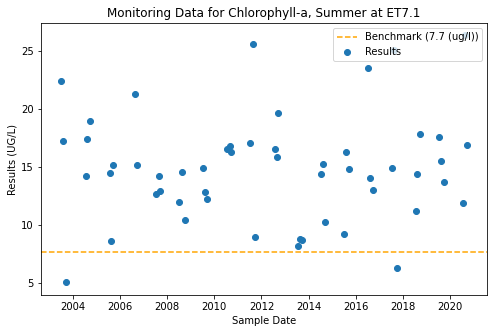

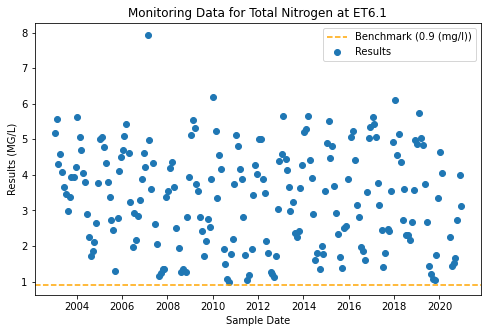

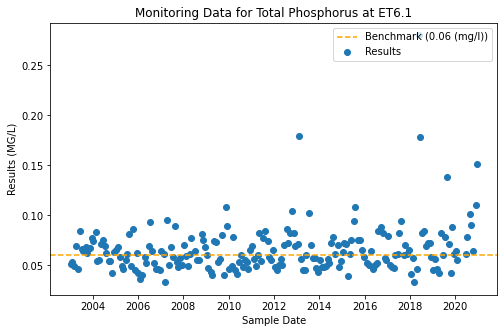

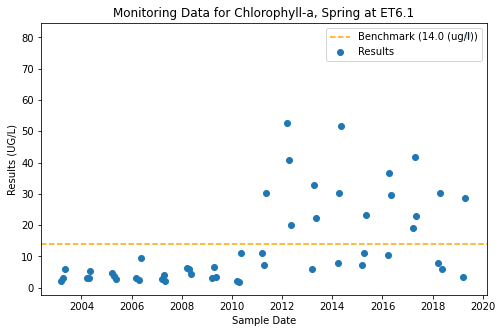

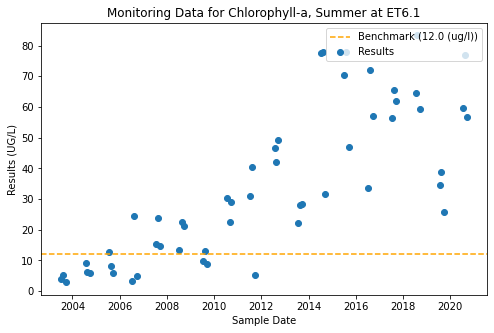

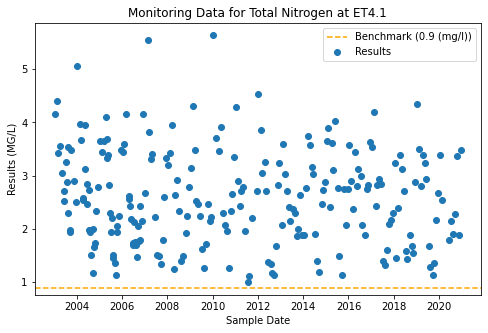

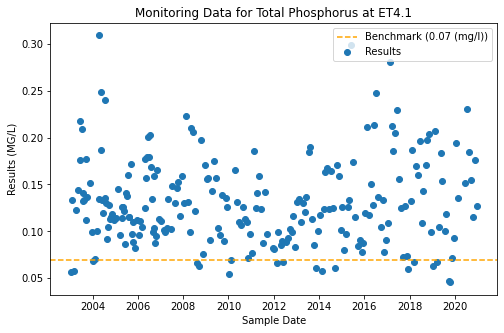

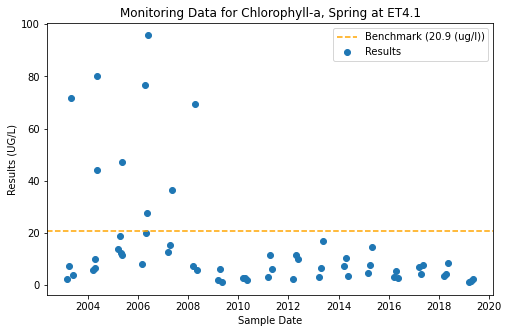

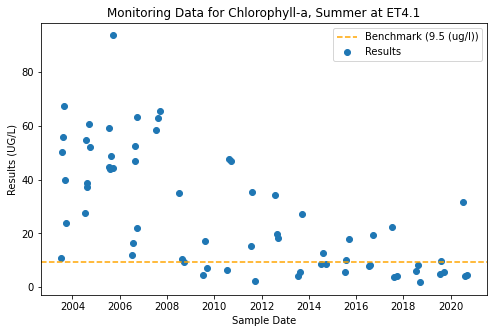

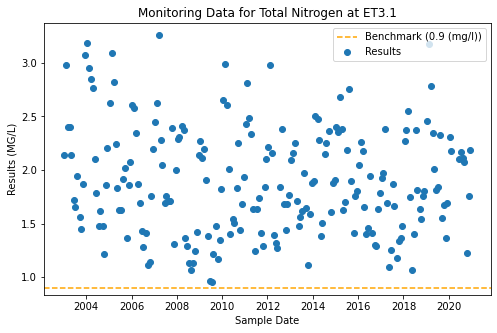

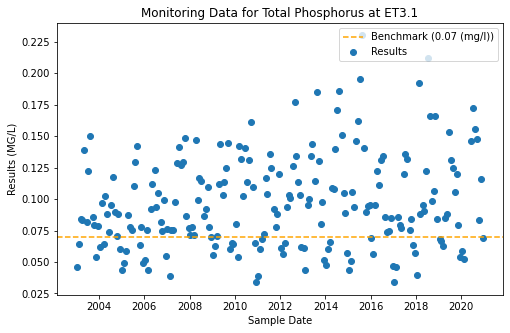

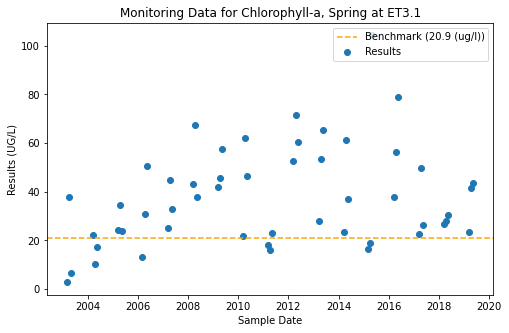

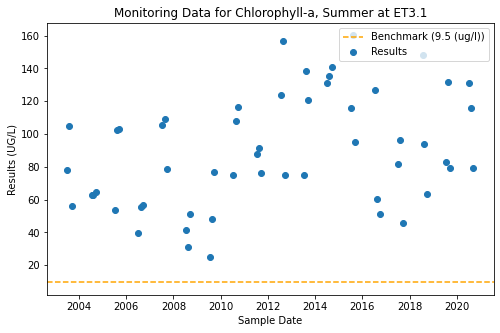

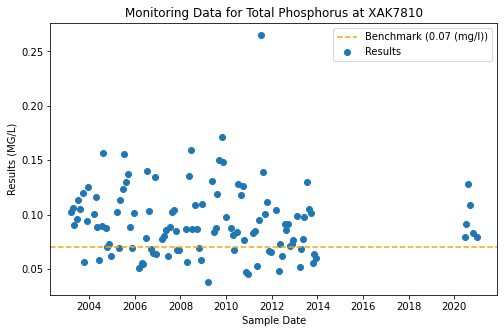

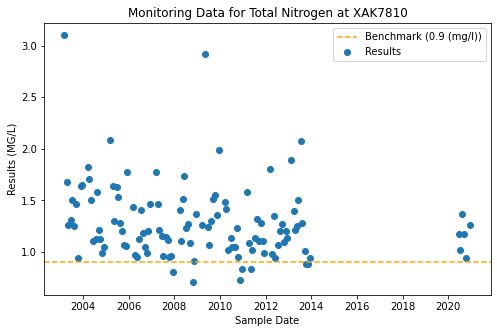

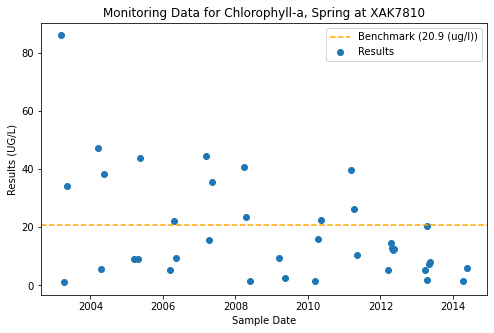

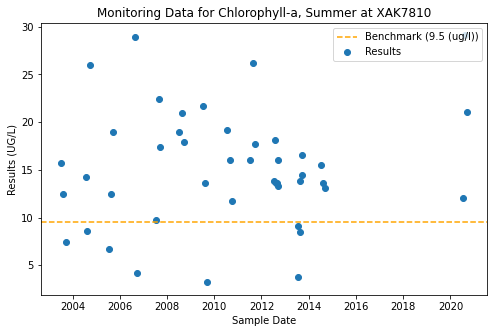

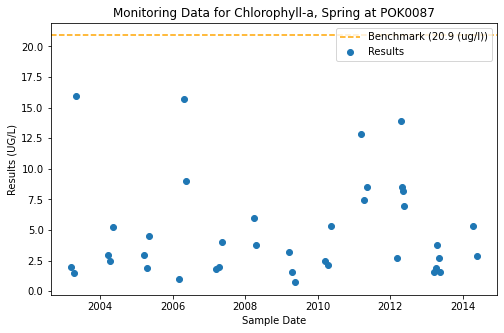

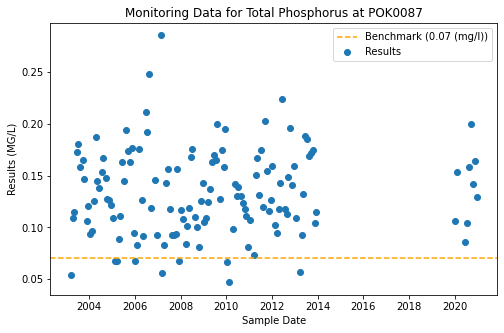

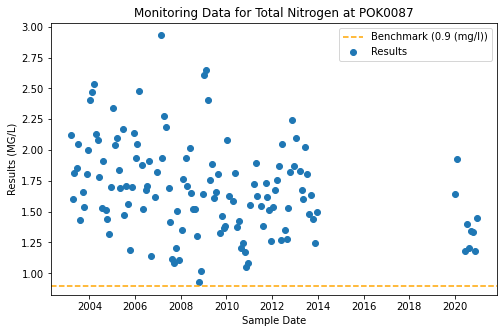

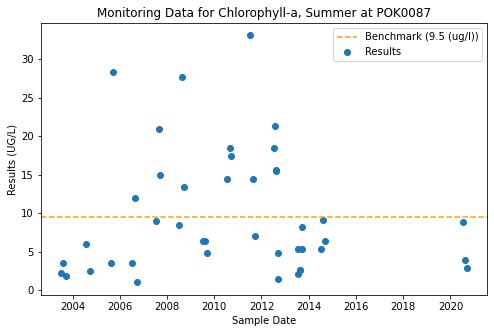

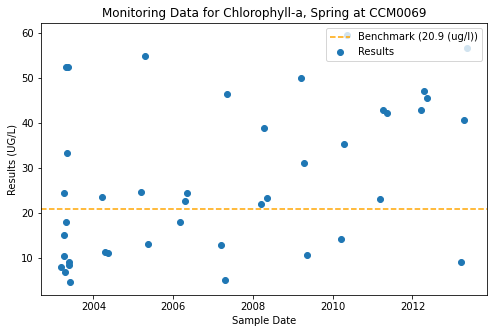

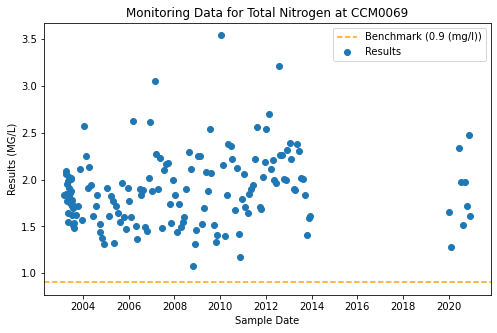

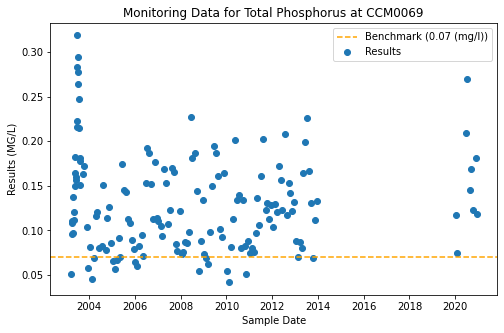

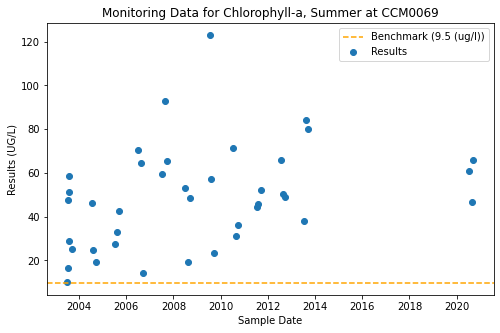

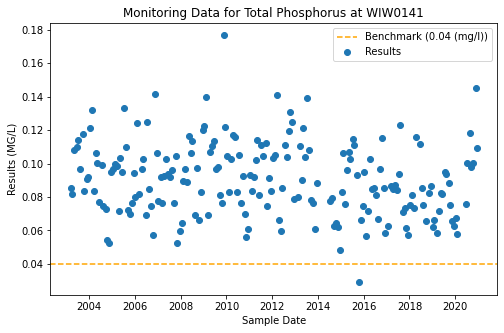

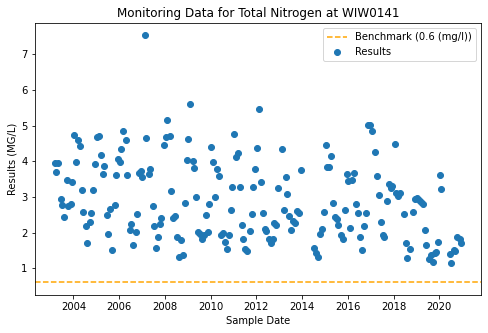

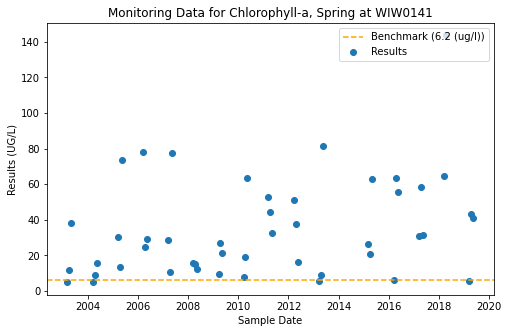

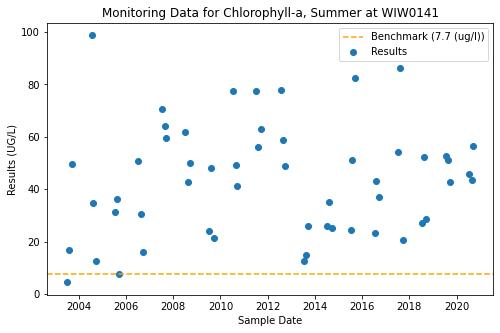

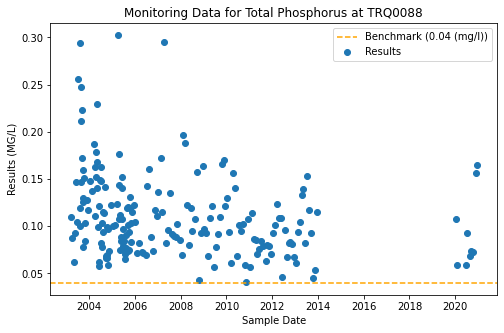

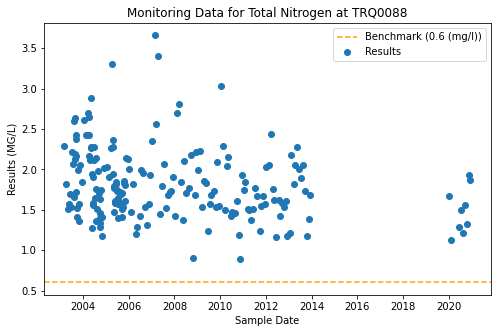

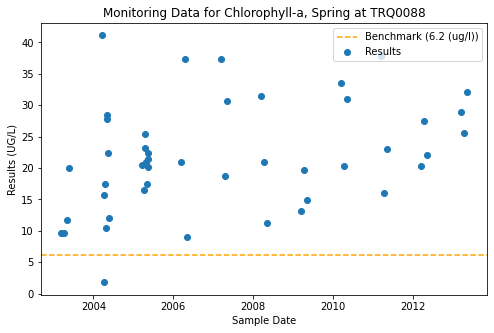

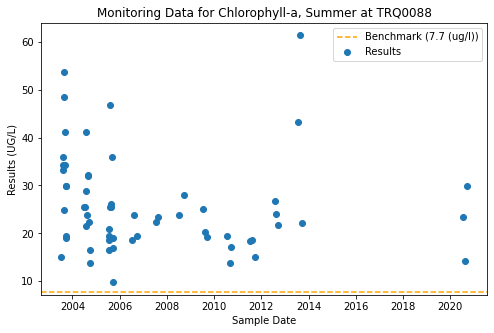

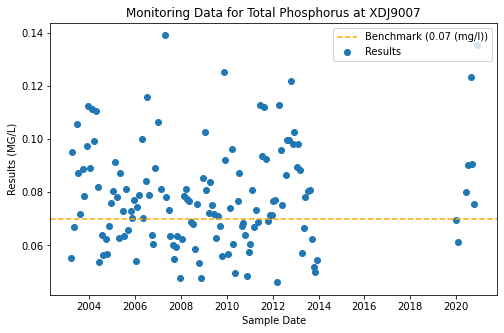

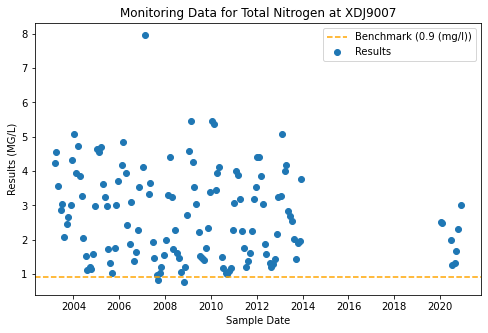

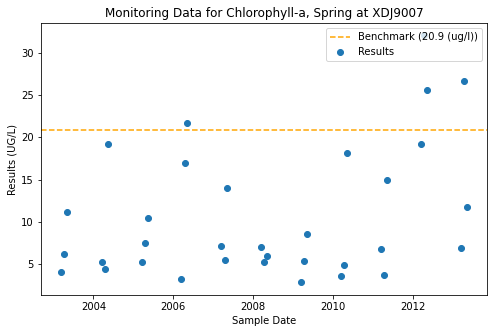

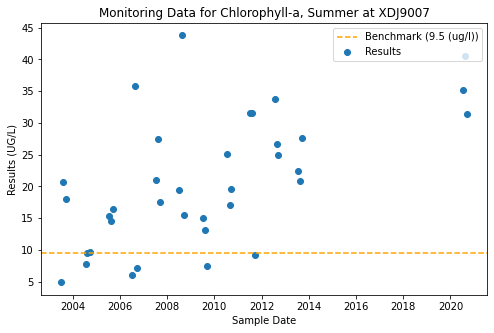

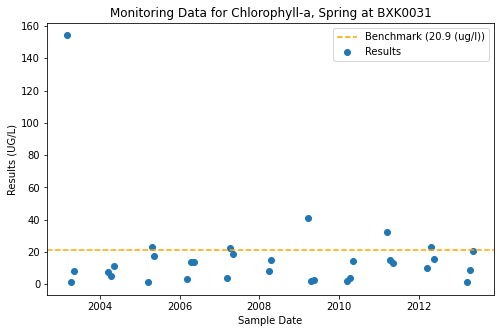

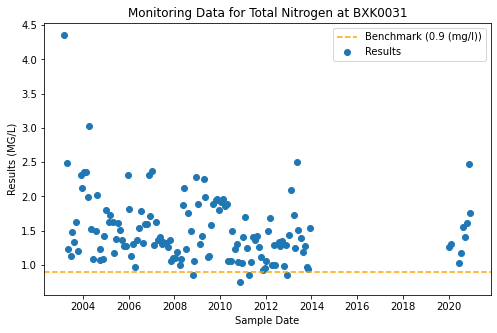

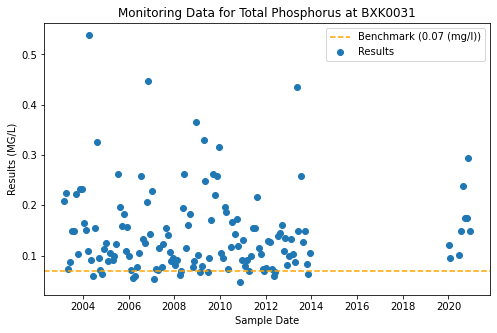

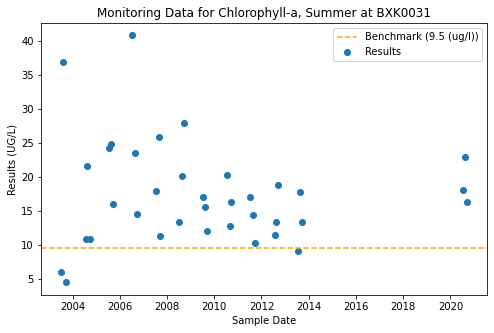

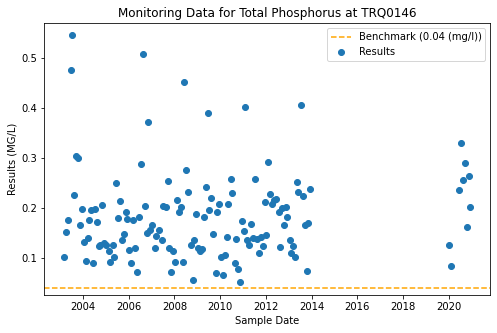

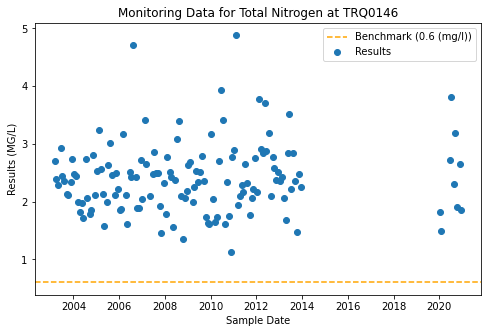

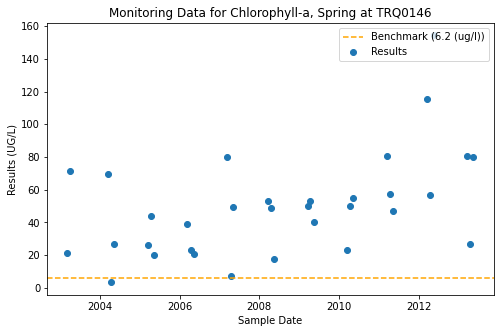

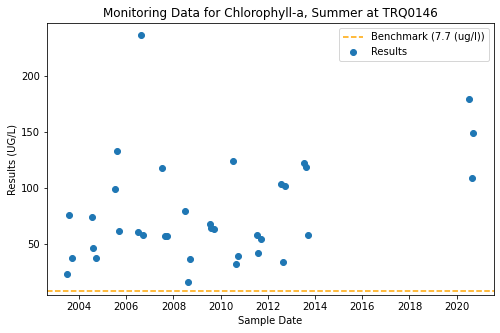

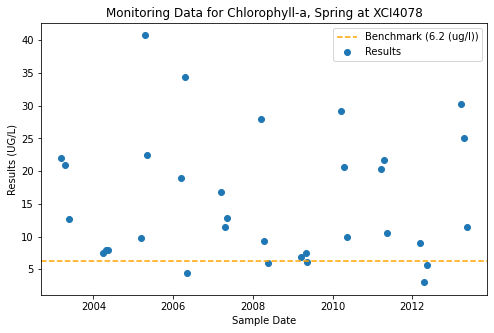

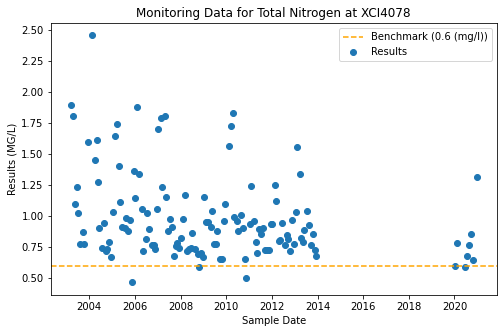

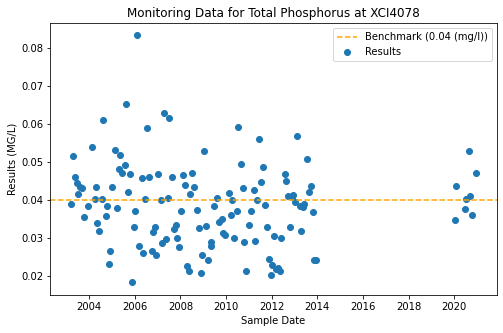

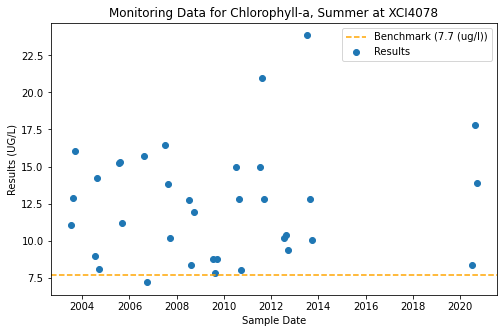

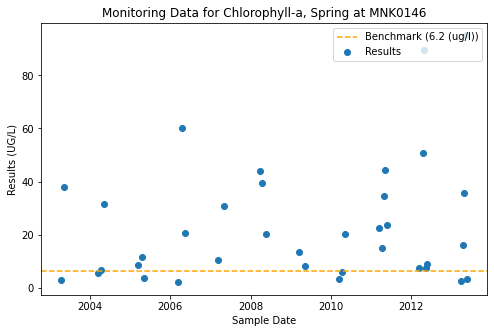

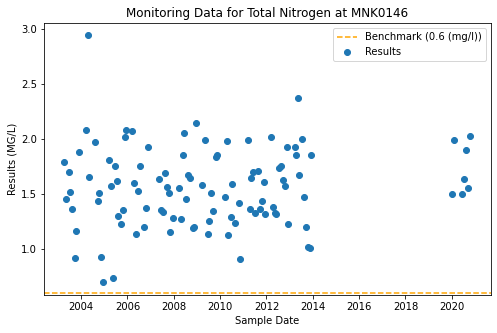

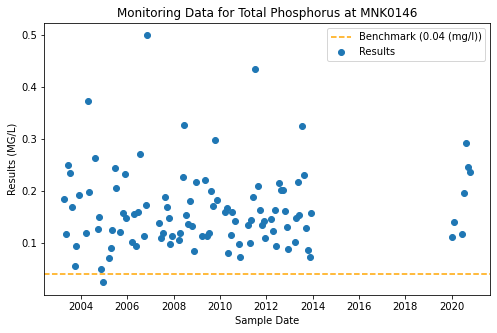

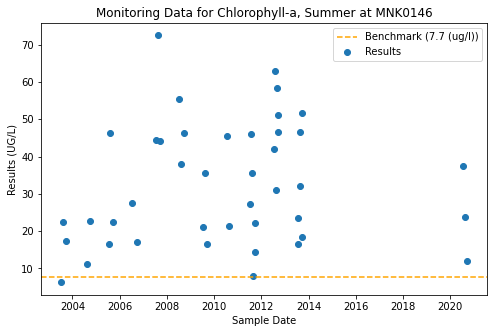

In [23]:
plots = scatters(final)

A couple of notes after looking at this first round of visualizations:
1. Some stations have sampled much more frequently than others, as they have denser plots.
2. Some stations have a huge gap in their data, where they stop measuring in what looks to be 2013, and then they pick back up again in 2020.
3. Some stations haven't even sampled since 2012 or 2014.
4. Most stations have contaminant concentrations well above their benchmarks, with only a select few with concentrations below the benchmark.
5. It's tough to determine trends from these plots alone, so we will go ahead and peform a Mann-Kendall Trend Test on the data.

### Missing Data

As we noted from the visualizations, some monitoring sites have gaps in their data, while others have stopped monitoring completely. This next section of code aims to identify those sites.

In [24]:
year_count = final[['Station', 'Year']].drop_duplicates().groupby('Station', as_index=False).count()
year_count

Station  Year
0   BXK0031    12
1   CCM0069    12
2    ET10.1    18
3     ET3.1    18
4     ET4.1    18
5     ET5.1    18
6     ET6.1    18
7     ET6.2    18
8     ET7.1    18
9     ET8.1    18
10  MNK0146    12
11  POK0087    13
12  TRQ0088    12
13  TRQ0146    12
14  WIW0141    18
15  XAK7810    13
16  XCI4078    12
17  XDJ9007    12

In [25]:
#those stations with less than 18 in the year column are the stations with missing data
missing_stations = list(year_count[year_count['Year'] < 18]['Station'])

#now lets separate out these stations into those with a gap in data versus those that just stopped monitoring
(final[final['Station'].isin(missing_stations)]
.loc[:,['Station','Year']]
.drop_duplicates()
.groupby('Station', as_index=False).max())

Station  Year
0  BXK0031  2020
1  CCM0069  2020
2  MNK0146  2020
3  POK0087  2020
4  TRQ0088  2020
5  TRQ0146  2020
6  XAK7810  2020
7  XCI4078  2020
8  XDJ9007  2020

It looks like all stations did start sampling again in 2020, but from the scatter plots above, we saw that some of the x-axis stopped at around 2012 or 2014. This must mean that for some of these locations, that haven't monitored all contaminants in 2020. Let's try breaking it out one further to see which contaminants at these locations were no longer being monitored.

In [26]:
#now lets separate out these stations into those with a gap in data versus those that just stopped monitoring, but including
#parameter this time
year_by_param = (final[final['Station'].isin(missing_stations)]
 .loc[:,['Station','Year','Parameter']]
 .drop_duplicates()
 .groupby(['Station', 'Parameter'], as_index=False).max())

year_by_param[year_by_param['Year'] != 2020]

Station              Parameter  Year
0   BXK0031  Chlorophyll-a, Spring  2013
4   CCM0069  Chlorophyll-a, Spring  2013
8   MNK0146  Chlorophyll-a, Spring  2013
12  POK0087  Chlorophyll-a, Spring  2014
16  TRQ0088  Chlorophyll-a, Spring  2013
20  TRQ0146  Chlorophyll-a, Spring  2013
24  XAK7810  Chlorophyll-a, Spring  2014
28  XCI4078  Chlorophyll-a, Spring  2013
32  XDJ9007  Chlorophyll-a, Spring  2013

This matches up with what MDE told us, that there was no water monitoring conducted from March through May of 2020 due to COVID, which is why on the `Chlorophyll-a, spring` plots above, they ended in 2013 or 2014. These `9` sites still have a data gap, so lets just confirm the last year each of them stopped monitoring before they picked back up again in 2020.

In [27]:
(final[final['Station'].isin(missing_stations) & (final['Year'] != 2020)]
 .loc[:,['Station','Year']]
.drop_duplicates()
.groupby('Station', as_index=False).max())

Station  Year
0  BXK0031  2013
1  CCM0069  2013
2  MNK0146  2013
3  POK0087  2014
4  TRQ0088  2013
5  TRQ0146  2013
6  XAK7810  2014
7  XCI4078  2013
8  XDJ9007  2013

It looks like most stopped monitoring in 2013, with two stations stopping in 2014. With the gaps in data figured out, we can move on to our trend analyses.

### Trend Analysis

We need to:
1. Perform a [Mann-Kendall Trend Test](https://www.statology.org/mann-kendall-test-python/) for each monitor, parameter, and season.
2. Compare 2003 base line to most recent three-year average for each contaminant at each monitor, and to the 2020 average for those monitors with data gaps.

#### Mann-Kendall Trend Test

In [28]:
#creating a function that performs the MK test on each iteration of monitor and parameter
def mann_kendall(df):
    """Takes in a whole dataframe of monitoring data and returns a dataframe of MK trend test results
    for each iteration of monitor, paramater, and season."""
    
    stations = list(final['Station'].unique())
    
    trends = []
    
    for station in stations:
        temp_1 = df[df['Station'] == station]
        params = list(temp_1.Parameter.unique())
        
        for param in params:
            temp_2 = temp_1[temp_1['Parameter'] == param]
            seasons = list(temp_2.Season.unique())
            
            for season in seasons:
                temp_3 = temp_2[temp_2['Season'] == season]
                values = list(temp_3['MeasureValue'])
                results = mk.original_test(values)
                trend = results.trend
                p = round(results.p,6)
                slope = round(results.slope,3)
                Tau = results.Tau
                trends.append([station,param,season,trend,p,slope,Tau])
    
    df = pd.DataFrame(trends, columns = ['Station', 'Parameter', 'Season', 'Trend', 'p-value', 'slope', 'Tau'])
    return df

grab confidence output from test in this function, can use to talk about (significance level)
and see what happens when removing earlier years

In [29]:
trends = mann_kendall(final)

In [30]:
#Let's see what the trends are for each station, parameter, and season
#without worrying about which stations had a monitoring gap.
(trends.drop(columns=['slope','Tau','p-value'])
 .groupby(['Parameter', 'Season', 'Trend'], as_index=False)
.count()
.pivot_table(index=['Parameter','Season'], columns='Trend', values='Station'))

Trend                         decreasing  increasing  no trend
Parameter             Season                                  
Chlorophyll-a, Spring Spring         3.0         6.0       9.0
Chlorophyll-a, Summer Summer         2.0         4.0      12.0
Total Nitrogen        Fall           2.0         NaN      16.0
                      Spring         8.0         NaN      10.0
                      Summer         7.0         2.0       9.0
                      Winter        10.0         NaN       8.0
Total Phosphorus      Fall           1.0         1.0      16.0
                      Spring         3.0         NaN      15.0
                      Summer         1.0         3.0      14.0
                      Winter         3.0         1.0      14.0

In [31]:
#lets look at the subset of locations that monitored during the whole time frame and don't have the data gap for 6-7 years
no_gap = final[~final.Station.isin(missing_stations)]

#trends
trends_nogap = mann_kendall(no_gap)

(trends_nogap.drop(columns=['slope','Tau','p-value'])
 .groupby(['Parameter', 'Season', 'Trend'], as_index=False)
.count()
.pivot_table(index=['Parameter','Season'], columns='Trend', values='Station'))

Trend                         decreasing  increasing  no trend
Parameter             Season                                  
Chlorophyll-a, Spring Spring         2.0         3.0       4.0
Chlorophyll-a, Summer Summer         1.0         2.0       6.0
Total Nitrogen        Fall           2.0         NaN       7.0
                      Spring         4.0         NaN       5.0
                      Summer         5.0         1.0       3.0
                      Winter         6.0         NaN       3.0
Total Phosphorus      Fall           NaN         1.0       8.0
                      Spring         1.0         NaN       8.0
                      Summer         NaN         2.0       7.0
                      Winter         2.0         NaN       7.0

In [32]:
#code block used to filter trend data for memo writing
trends[(trends['Parameter'] == 'Chlorophyll-a, Summer') & (trends['Trend'] == 'increasing')]

Station              Parameter  Season       Trend   p-value  slope  \
59     ET6.1  Chlorophyll-a, Summer  Summer  increasing  0.000000  1.249   
79     ET3.1  Chlorophyll-a, Summer  Summer  increasing  0.007237  0.763   
109  CCM0069  Chlorophyll-a, Summer  Summer  increasing  0.007620  0.834   
139  XDJ9007  Chlorophyll-a, Summer  Summer  increasing  0.000488  0.560   

          Tau  
59   0.626834  
79   0.252271  
109  0.294872  
139  0.407937

In [33]:
#writing to Excel
trends.to_excel('02_Trends by Season.xlsx',index=False)

#### Benchmark to Three-year Average Comparison

In [34]:
#getting stations and parameters that measured during the summer from 2018-2020
years = final[(final.Year.isin([2018, 2019, 2020])) & (final.Season == 'Summer')]

#calculating just 2020 average for those stations with a gap in data
gap_avg = (years[years['Station'].isin(missing_stations)]
          .groupby(['Station', 'Parameter'], as_index=False).mean())
gap_avg['Three_year_Average'] = round(gap_avg['MeasureValue'], 2)
gap_avg.drop(columns = ['Year', 'Month', 'MeasureValue'], inplace=True)
gap_avg['percent_over'] = round(((gap_avg.Three_year_Average - gap_avg.Threshold)/gap_avg.Threshold)*100,1)
gap_avg['Average_Type'] = 'Just 2020'

#calculating 2018-2020 average for those stations without a gap in data
nogap_avg = (years[~years['Station'].isin(missing_stations)]
          .groupby(['Station', 'Parameter'], as_index=False).mean())
nogap_avg['Three_year_Average'] = round(nogap_avg['MeasureValue'], 2)
nogap_avg.drop(columns = ['Year', 'Month', 'MeasureValue'], inplace=True)
nogap_avg['percent_over'] = round(((nogap_avg.Three_year_Average - nogap_avg.Threshold)/nogap_avg.Threshold)*100,1)
nogap_avg['Average_Type'] = 'All Three'

#combining
total_avg = pd.concat([gap_avg, nogap_avg])

In [35]:
#writing to Excel
total_avg.to_excel('03_Benchmark Comparisons_Summer.xlsx',index=False)

#### Change in Concentration for Summer Trends

In [36]:
#grabbing raw data for just those stations with increasing or decreasing trends
changes = trends[(trends['Trend'] != 'no trend') & (trends['Season'] == 'Summer')]
change_data = pd.merge(final, changes, how='inner', on=['Station', 'Parameter', 'Season'])

#calculating 2003-2005 average for each station/parameter
early_avg = (change_data[change_data['Year'].isin([2003, 2004, 2005])]
             .loc[:,['Station','Parameter','Trend','MeasureValue']]
            .groupby(['Station', 'Parameter', 'Trend'], as_index=False)
            .mean())
early_avg['Historic_Average'] = round(early_avg['MeasureValue'],2)
early_avg.drop(columns=['MeasureValue'], inplace=True)

#joining with averages from benchmark data
change_trends = pd.merge(early_avg, total_avg[['Station', 'Parameter', 'Three_year_Average']],
                        how='left', on=['Station', 'Parameter'])
change_trends['Percent_Change'] = round(((change_trends.Three_year_Average - change_trends.Historic_Average)/change_trends.Historic_Average)*100,1)

In [37]:
#writing to excel
change_trends.to_excel('04_Percent Change for Changing Trends.xlsx',index=False)

## Visualizations

In [46]:
visuals = pd.merge(final, trends, how='left', on=['Station', 'Parameter', 'Season'])
summer_viz = visuals[visuals['Season'] == 'Summer']

In [48]:
#creating a function that visualizes the concentrations over time for each iteration of monitor, parameter, and season
def scatter_final(df,):
    """Takes in a whole dataframe of monitoring data and a list of stations, and returns a scatter plot of test results
    for each iteration of monitor, paramater, and season."""
    
    stations = list(df.Station.unique())
    
    colors = {'no trend': 'blue', 'increasing': 'red', 'decreasing': 'green'}
    
    plots = []
    
    for station in stations:
        temp_1 = df[df['Station'] == station]
        params = list(temp_1.Parameter.unique())
        
        for param in params:
            temp_2 = temp_1[temp_1['Parameter'] == param]
            fig = plt.figure(figsize=(8,5))
            threshold = round(list(temp_2['Threshold'])[0],2)
            unit = list(temp_2['Unit'])[0].lower()
            plt.scatter(x=temp_2['SampleDate'], y=temp_2['MeasureValue'], c=temp_2.Trend.map(colors), label = 'Results')
            plt.axhline(y= threshold, color = 'orange', linestyle = 'dashed', label = 'Benchmark ({} ({}))'.format(threshold,unit))
            plt.xlabel('Sample Date')
            plt.ylabel('Results ({})'.format(list(temp_2['Unit'].unique())[0]))
            plt.title('Monitoring Data for {} at {}'.format(param, station))
            plt.legend(loc='upper right')
            plots.append(fig)
    
    return plots

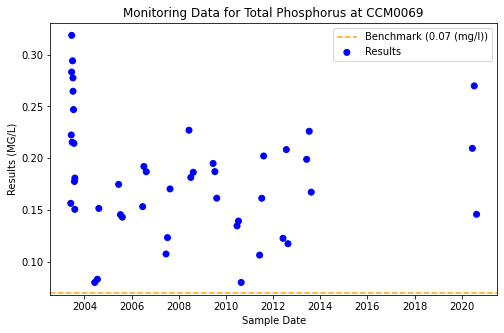

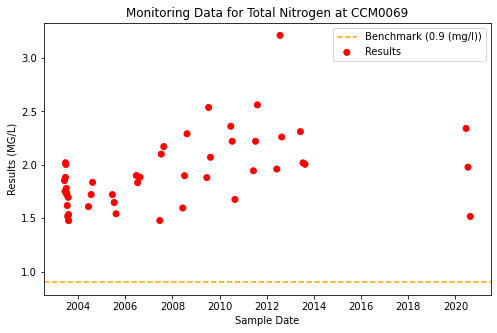

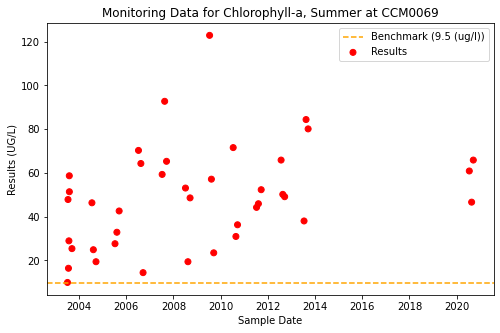

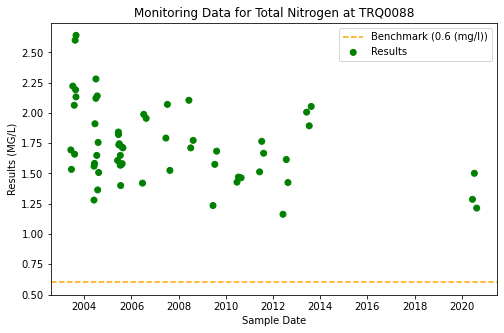

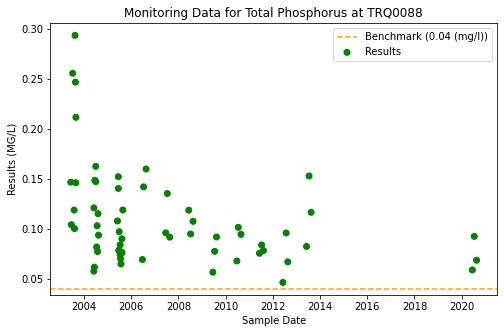

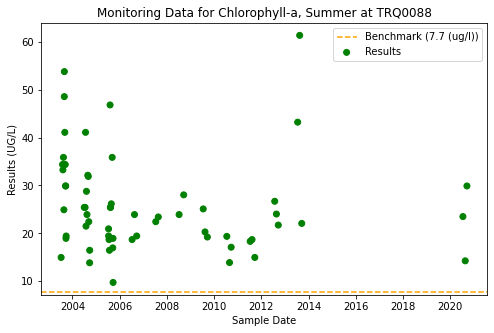

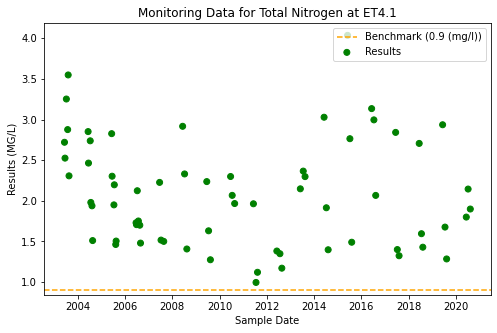

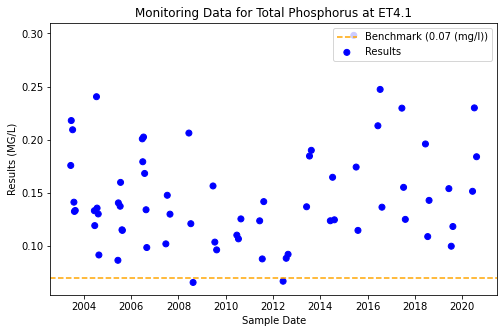

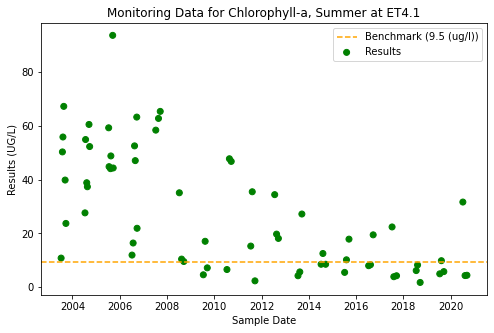

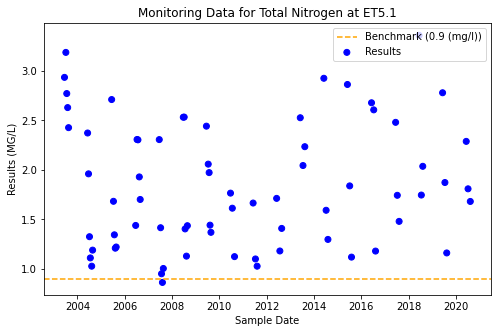

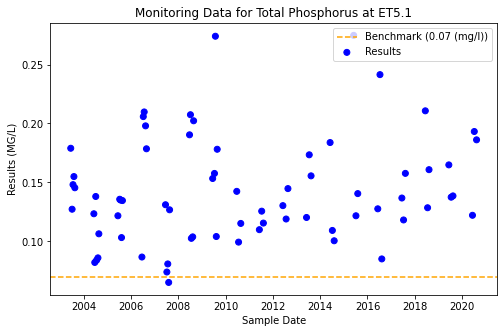

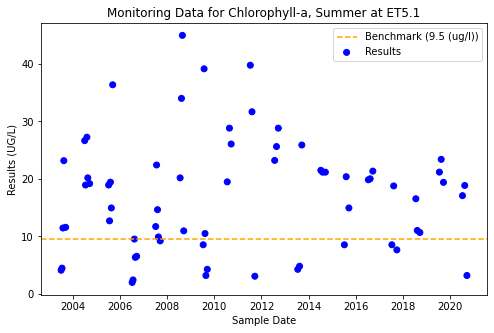

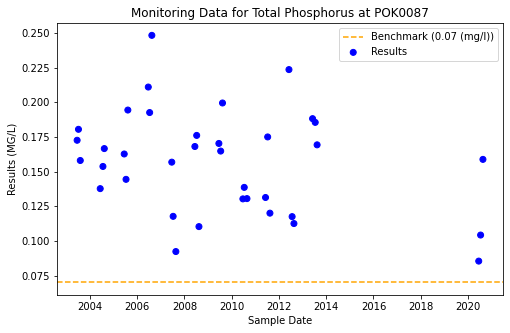

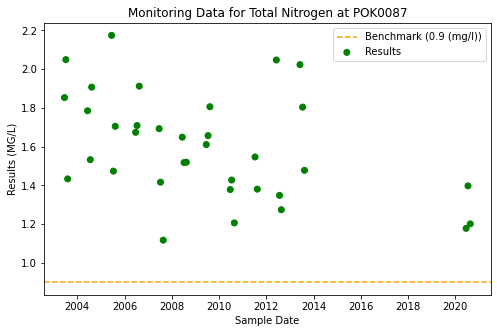

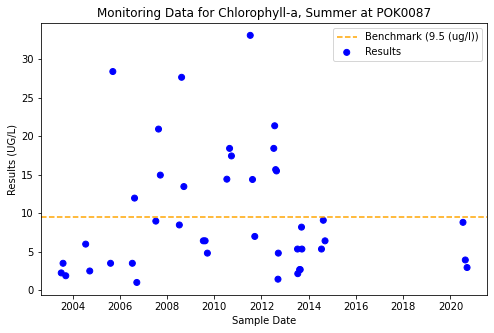

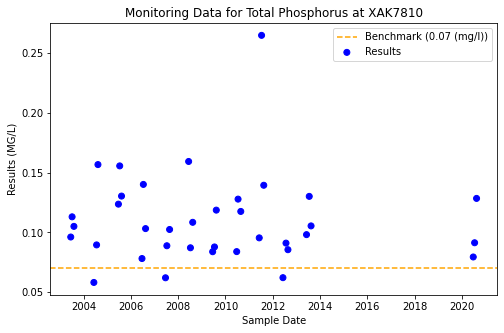

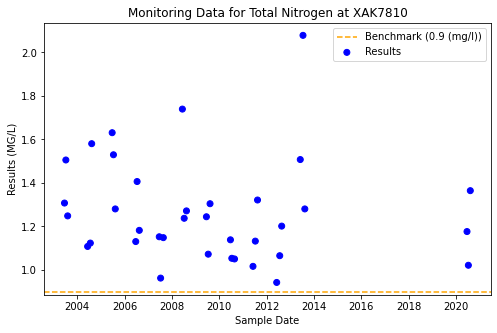

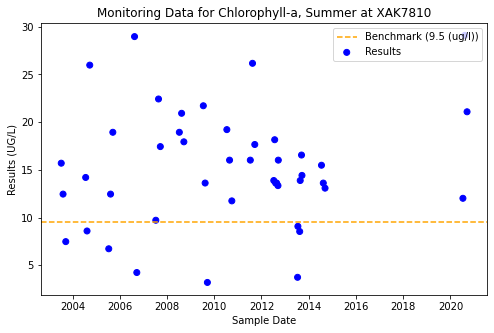

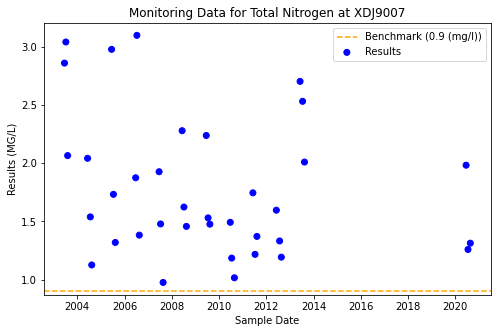

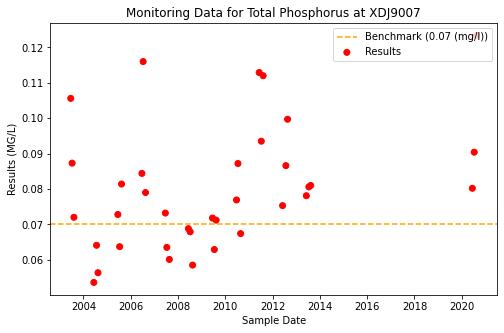

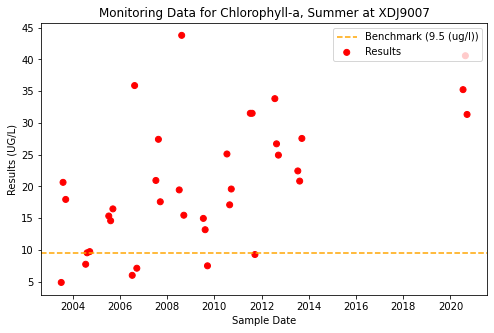

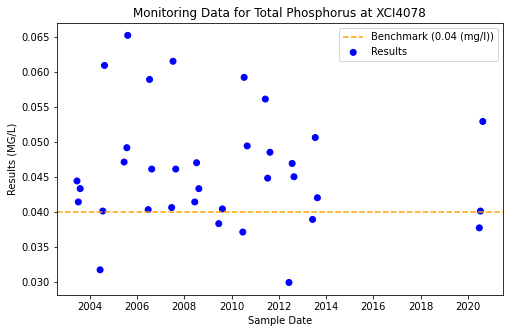

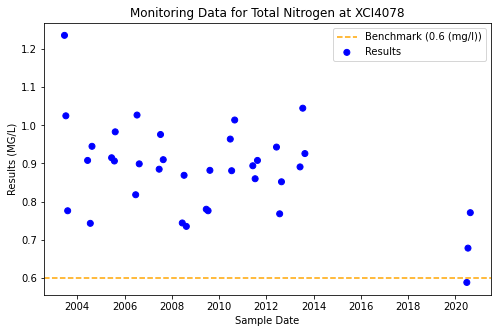

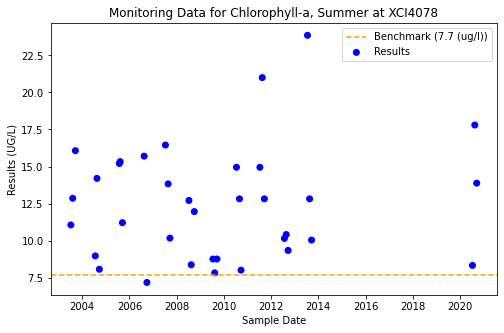

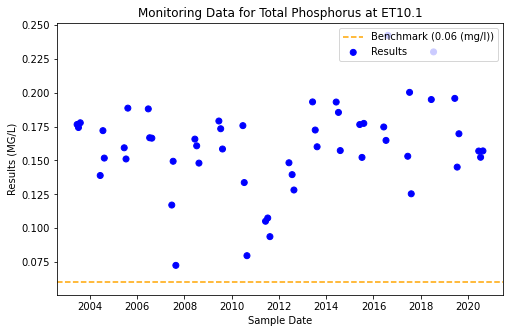

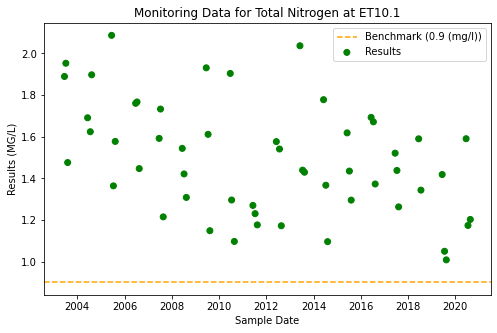

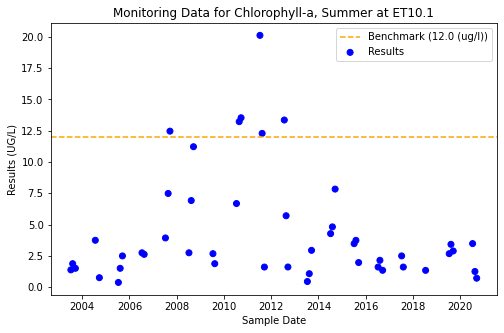

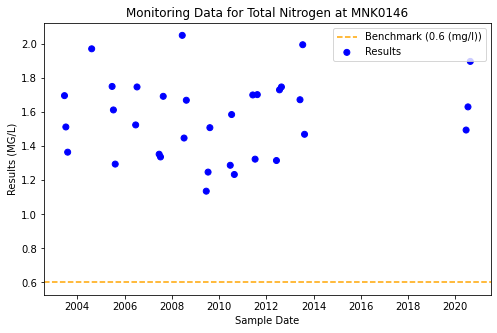

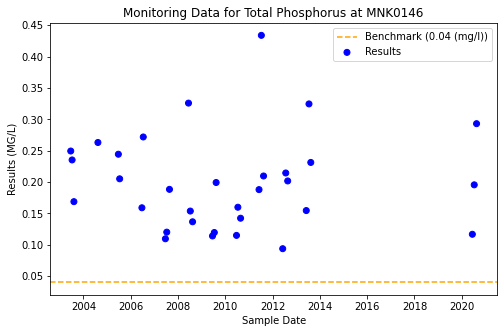

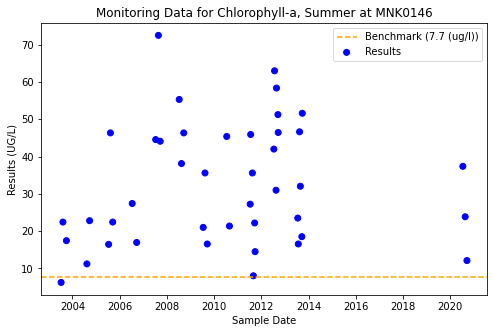

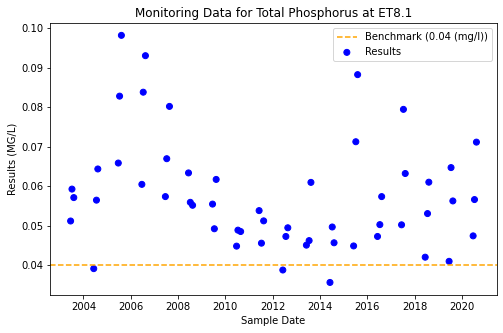

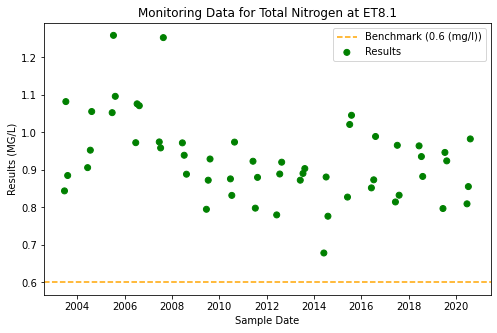

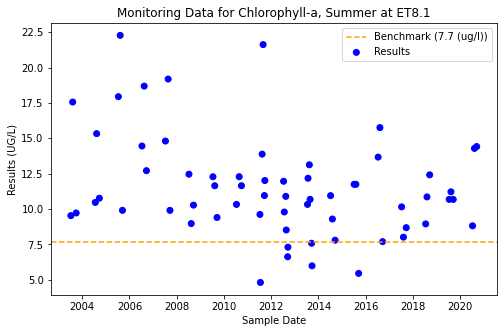

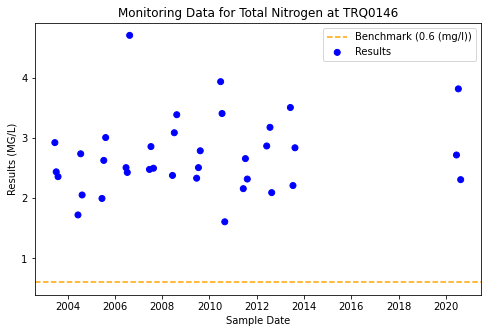

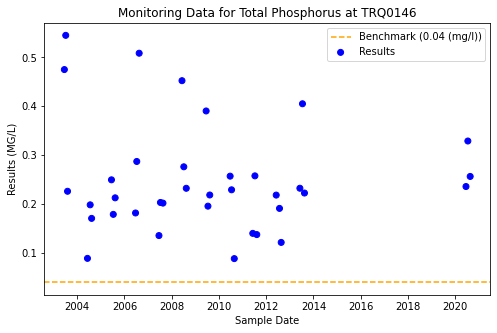

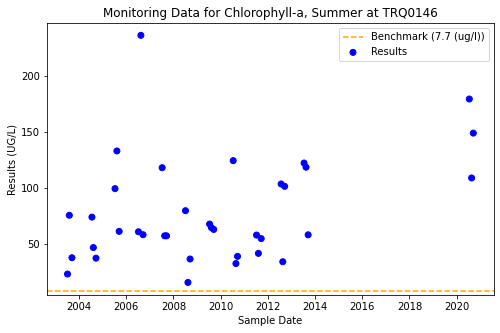

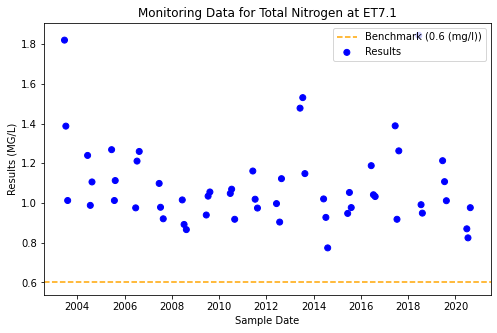

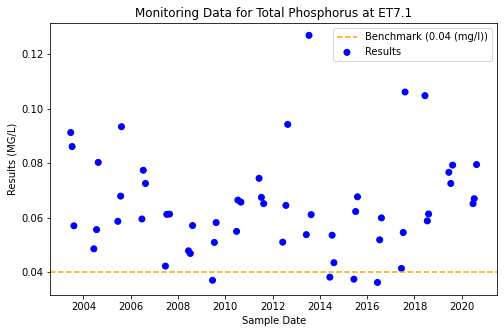

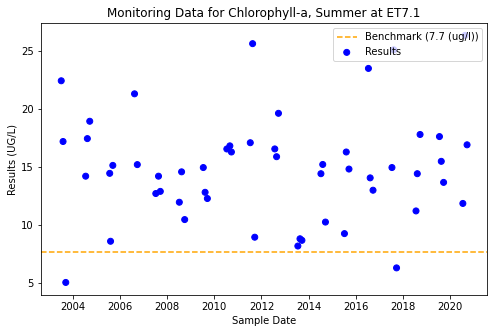

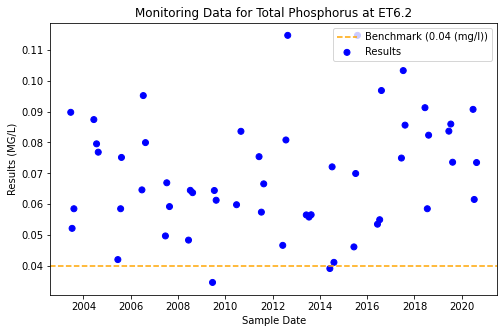

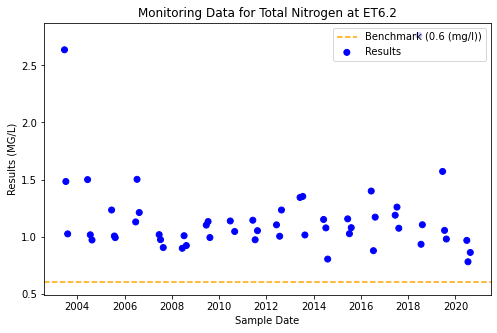

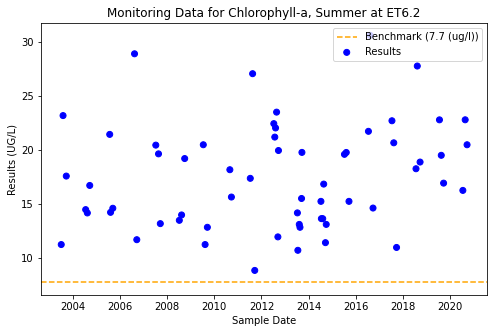

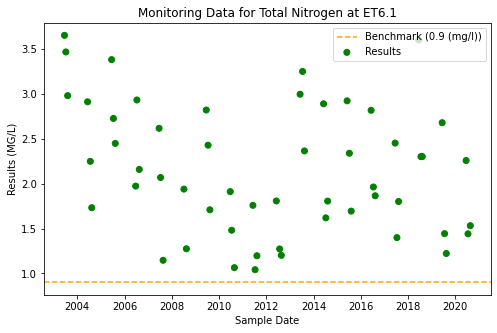

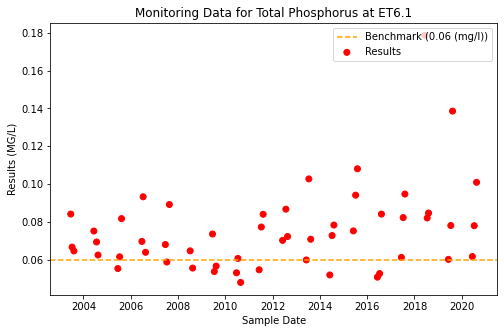

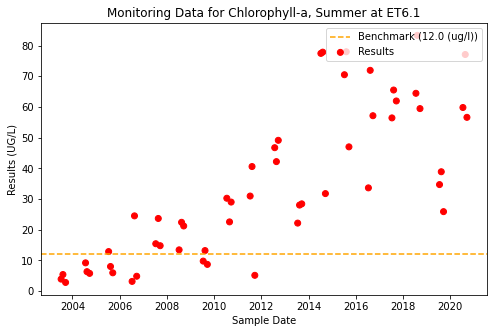

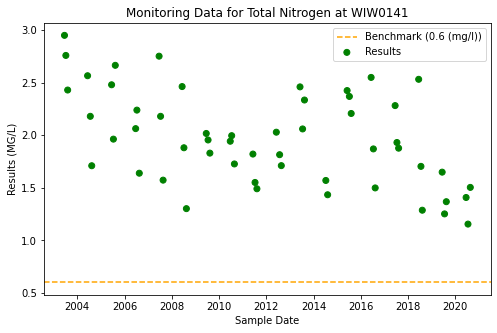

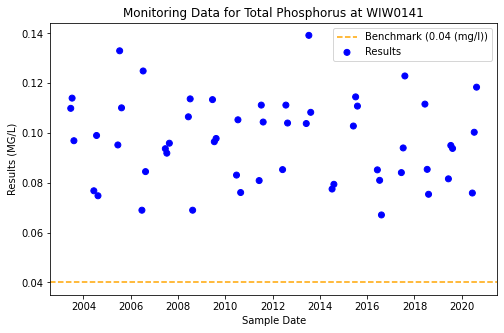

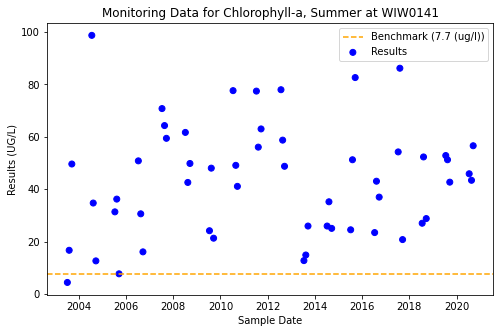

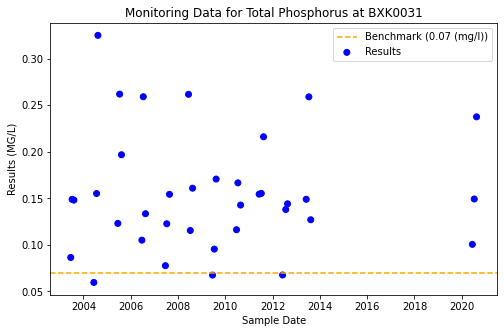

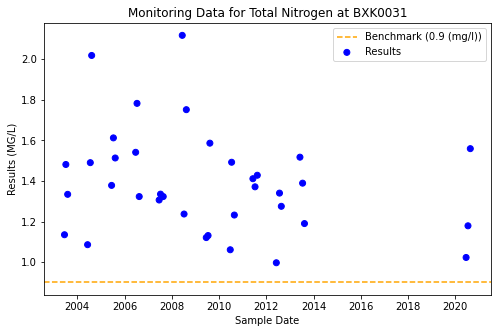

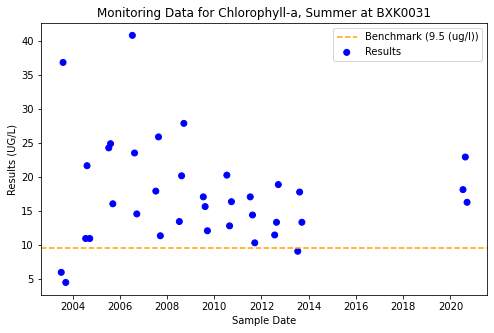

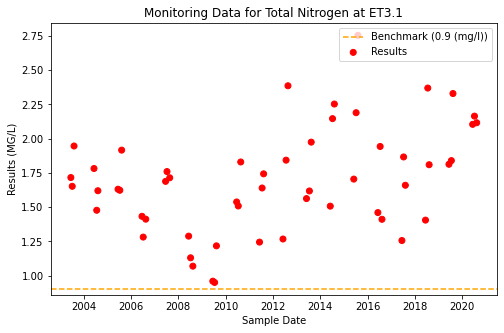

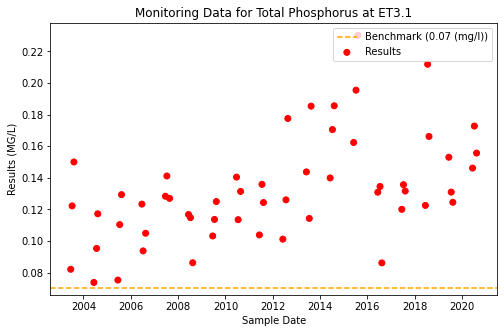

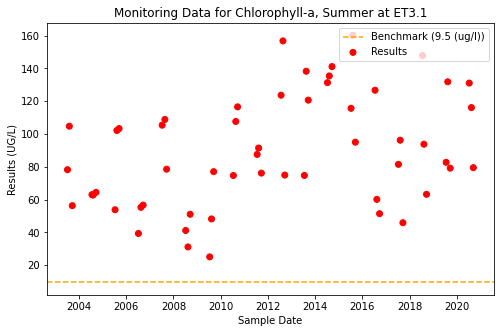

In [49]:
plots = scatter_final(summer_viz)

In [51]:
from matplotlib.backends.backend_pdf import PdfPages

with PdfPages('Trend Visuals_Summer.pdf') as pdf:
    for fig in plots:
        pdf.savefig(fig)

### 2020 Average (and 2020-2018 average) compared to 2011-2013 average

In [91]:
#average by station/parameter for 2020
year_20 = final[final['Year'] == 2020]
year_20.drop(columns=['Year', 'Month', 'Threshold'], inplace=True)
year_20['Timeframe'] = 'New'
avg_20 = year_20.groupby(['Station', 'Parameter', 'Unit'], as_index=False)['MeasureValue'].agg(['mean','max','min']).round(2)
avg_20.reset_index(inplace=True)
avg_20['2020 Range'] = avg_20[['min','max']].apply(lambda x: '{} - {}'.format(x[0],x[1]), axis=1)
avg_20.drop(columns=['max','min'],inplace=True)
avg_20.rename(columns={'mean':'2020 Average Conc.'}, inplace=True)

#average by station/parameter for 2018-2020
year_recent = final[final['Year'].isin([2018,2019,2020])]
year_recent.drop(columns=['Year', 'Month', 'Threshold'], inplace=True)
avg_recent = year_recent.groupby(['Station', 'Parameter', 'Unit'], as_index=False)['MeasureValue'].agg(['mean','max','min']).round(2)
avg_recent.reset_index(inplace=True)
avg_recent['2018-2020 Range'] = avg_recent[['min','max']].apply(lambda x: '{} - {}'.format(x[0],x[1]), axis=1)
avg_recent.drop(columns=['max','min'],inplace=True)
avg_recent.rename(columns={'mean':'2018-2020 Average Conc.'}, inplace=True)

In [92]:
#average by station/parameter for 2011-2013
year_other = final[final['Year'].isin([2011, 2012, 2013])]
year_other.drop(columns=['Year', 'Month', 'Threshold'], inplace=True)
year_other['Timeframe'] = 'Old'
avg_other = year_other.groupby(['Station', 'Parameter', 'Unit'], as_index=False)['MeasureValue'].agg(['mean','max','min']).round(2)
avg_other.reset_index(inplace=True)
avg_other['2011-2013 Range'] = avg_other[['min','max']].apply(lambda x: '{} - {}'.format(x[0],x[1]), axis=1)
avg_other.drop(columns=['max','min'],inplace=True)
avg_other.rename(columns={'mean':'2011-2013 Average Conc.'}, inplace=True)

In [93]:
#dataframe for t-test
df_ttest = pd.concat([year_20, year_other])
df_ttest = df_ttest[df_ttest['Parameter'] != 'Chlorophyll-a, Spring']

t_stations = list(df_ttest.Station.unique())

In [94]:
#function for independent samples t-test (paired requires same length)
def t_test(df, stations):
    """Takes one dataframes and performs a t-test for each iteration of monitoring location and parameter between the
    2011-2013 data and 2020 data.
    
    Parameters:
    df - dataframe data
    stations - list of stations"""

    values = []
    
    for station in stations:
        df1 = df[df['Station'] == station]
        params = list(df1.Parameter.unique())
        
        for param in params:
            df2 = df1[df1['Parameter'] == param]
            old = df2[df2['Timeframe'] == 'Old']
            new = df2[df2['Timeframe'] == 'New']
            p_value = round(stats.ttest_ind(old['MeasureValue'], new['MeasureValue'])[1],4)
            values.append([station,param,p_value])
            
    results = pd.DataFrame(values, columns = ['Station', 'Parameter', 'p-value'])
    results['Significant'] = np.where(results['p-value'] < 0.05, 'Yes', 'No')
    return results

In [95]:
t_df = t_test(df_ttest, t_stations)

In [96]:
#joining averages and comparing
new_avg = pd.merge(avg_20, avg_recent, how='outer', on=['Station', 'Parameter', 'Unit'])
both_avg = pd.merge(new_avg, avg_other, how='outer', on=['Station', 'Parameter', 'Unit'])
with_ttest = pd.merge(both_avg, t_df, how='outer', on=['Station', 'Parameter'])

### Writing CSVs

In [98]:
average[['Station','Parameter','Unit','Three_year_Average','Threshold','percent_over']].to_excel('03_Benchmark Comparisons_SpSu.xlsx',index=False)
with_ttest.to_excel('04_2020 to 2011-2013 Comparison_SpSu.xlsx',index=False)

### Mann-Kendall Trend Test

In [74]:
stations = list(final_su.Station.unique())

In [75]:
trends_su = mann_kendall(final_su, stations)
trends_su[trends_su['Trend'] == 'increasing']

Station              Parameter       Trend   p-value  slope       Tau
0   CCM0069         Total Nitrogen  increasing  0.002005  0.013  0.332172
2   CCM0069  Chlorophyll-a, Summer  increasing  0.007620  0.834  0.294872
14  MNK0146       Total Phosphorus  increasing  0.039447  0.003  0.258065
16  XDJ9007  Chlorophyll-a, Summer  increasing  0.000488  0.560  0.407937
17  XDJ9007       Total Phosphorus  increasing  0.016507  0.001  0.280952
30    ET6.1  Chlorophyll-a, Summer  increasing  0.000000  1.249  0.626834
32    ET6.1       Total Phosphorus  increasing  0.000726  0.000  0.317261
48    ET3.1         Total Nitrogen  increasing  0.007567  0.009  0.250874
49    ET3.1       Total Phosphorus  increasing  0.009843  0.001  0.242488
50    ET3.1  Chlorophyll-a, Summer  increasing  0.007237  0.763  0.252271

In [76]:
trend_final_su = pd.merge(trends_su, coords, how='left')

### Visualizations

In [77]:
visuals_su = pd.merge(final_su, trends_su, how='left', on=['Station', 'Parameter'])

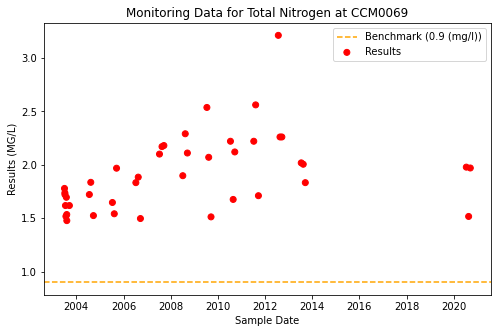

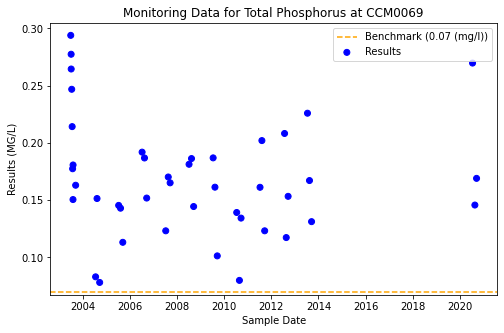

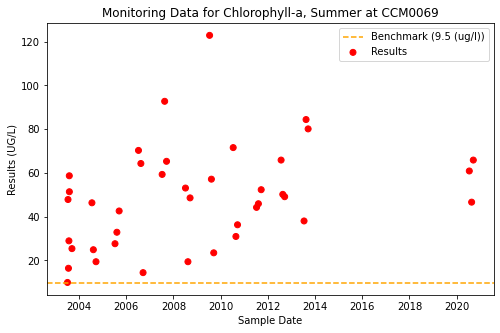

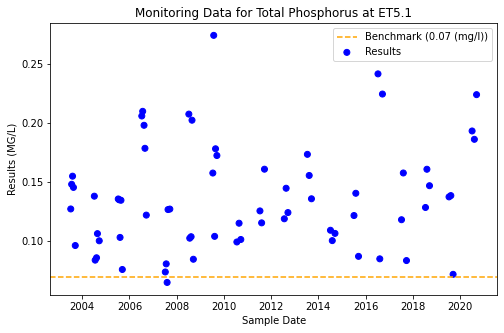

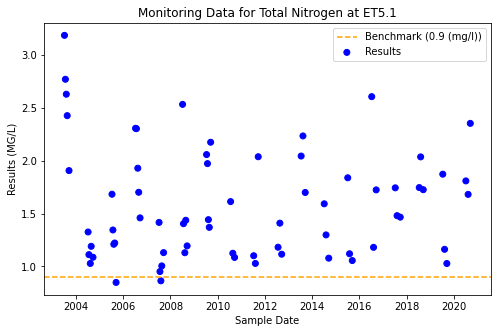

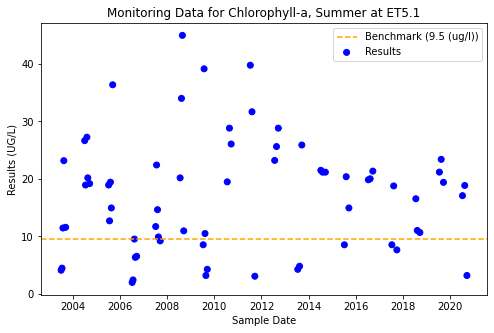

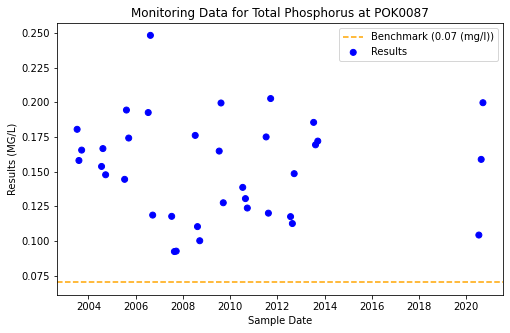

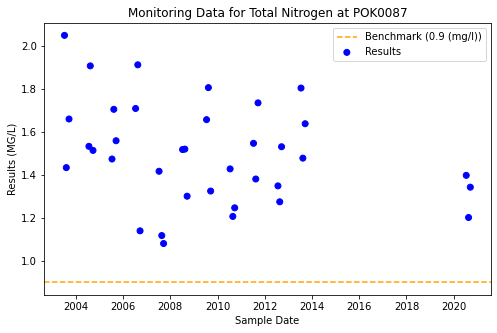

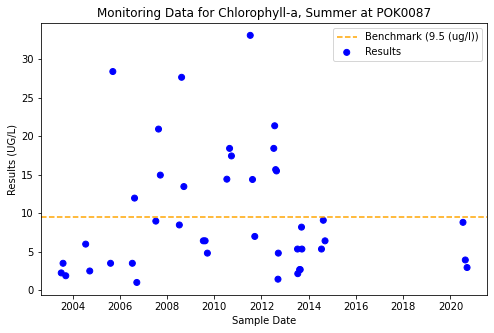

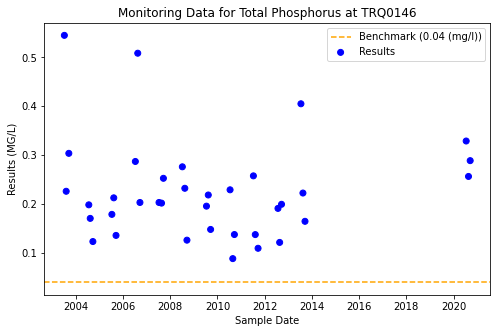

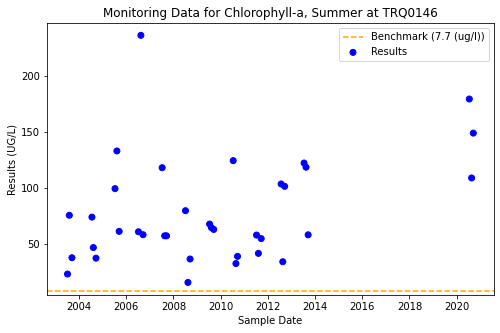

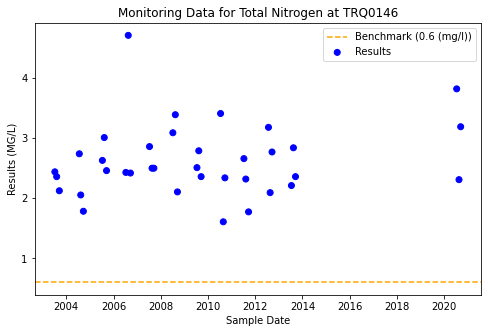

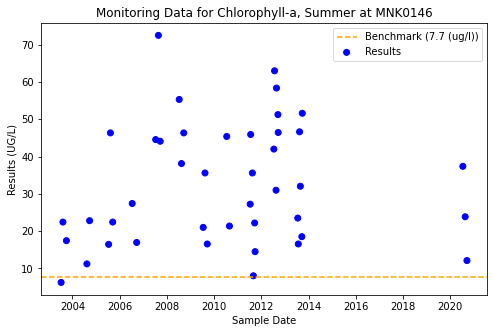

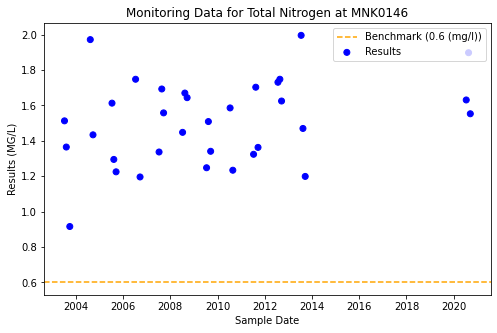

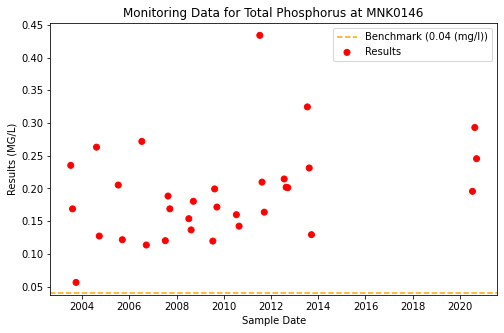

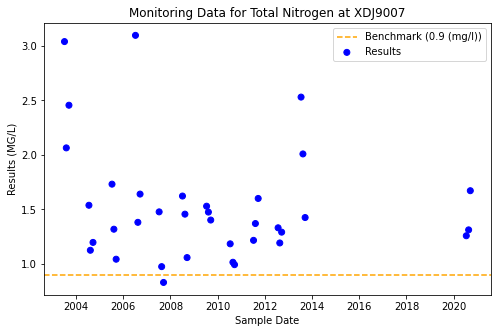

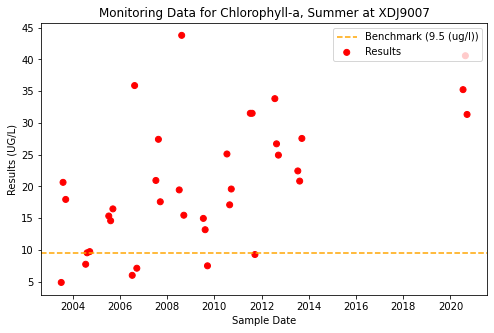

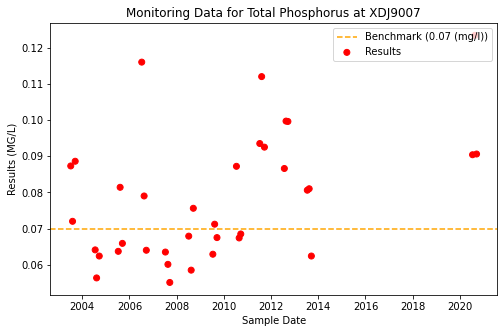

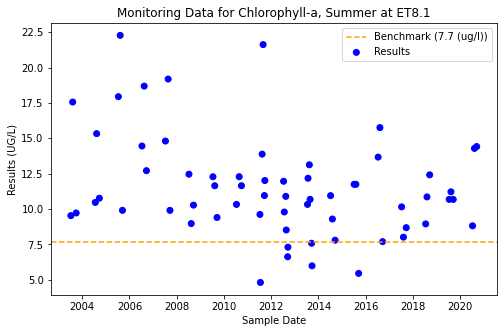

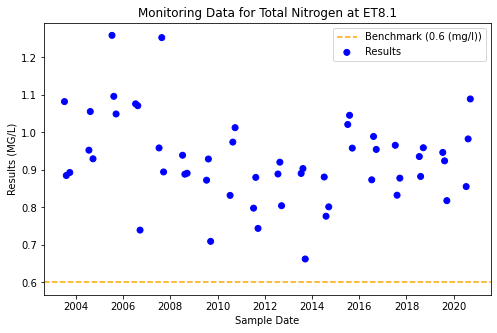

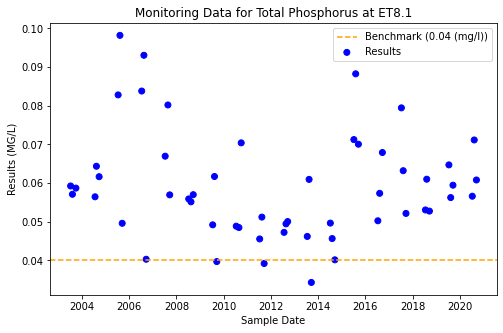

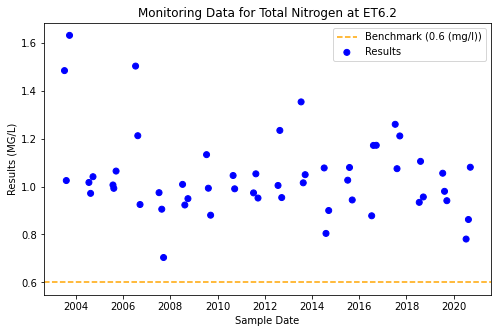

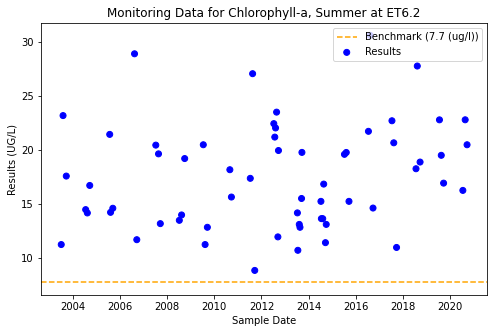

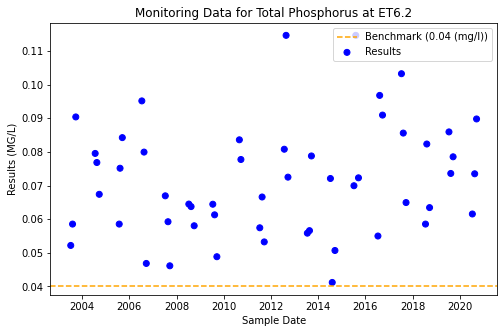

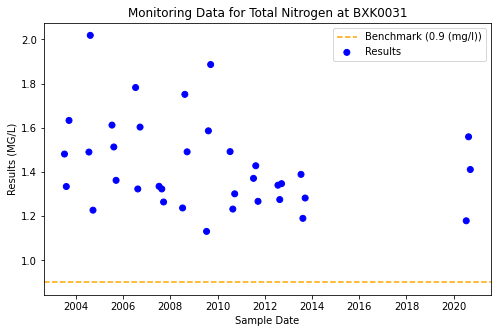

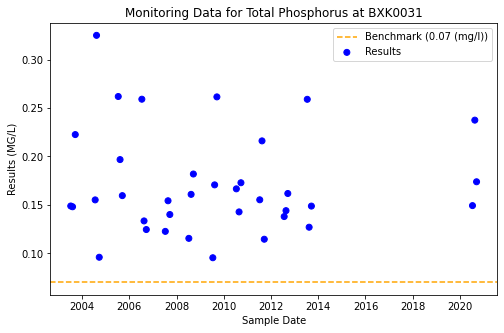

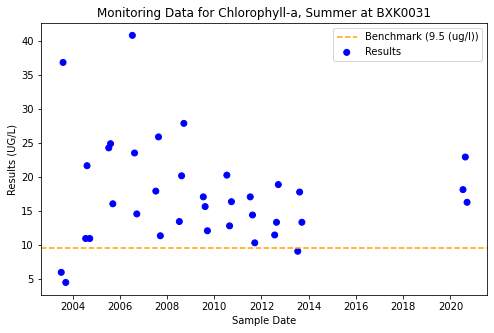

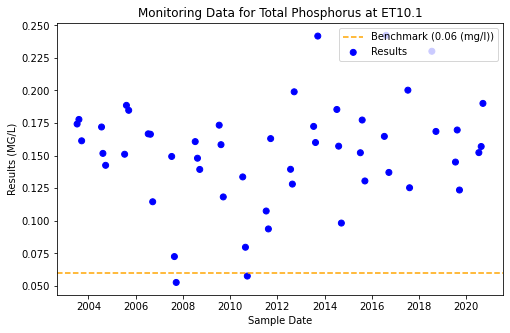

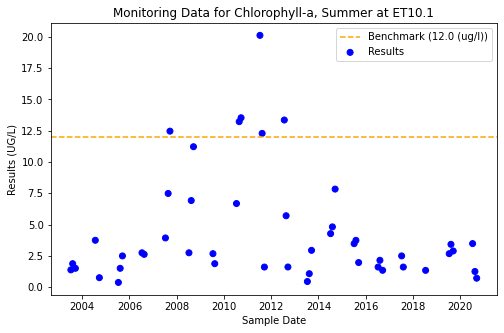

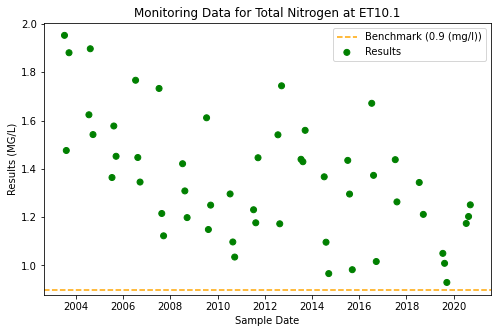

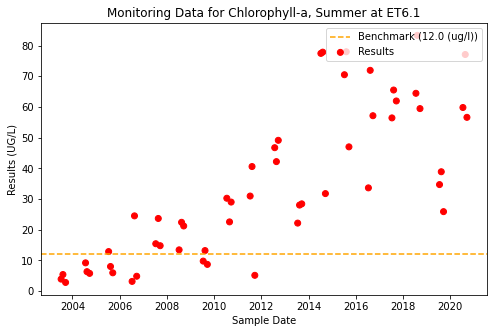

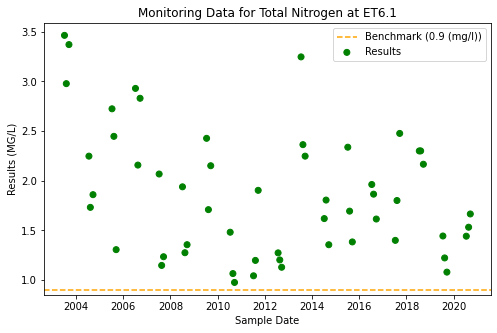

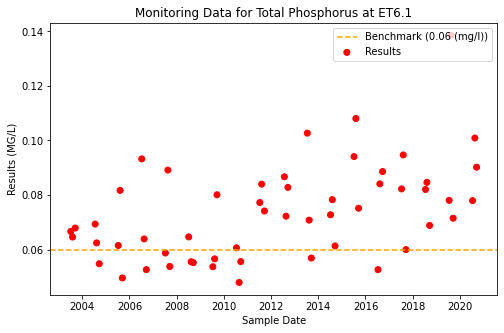

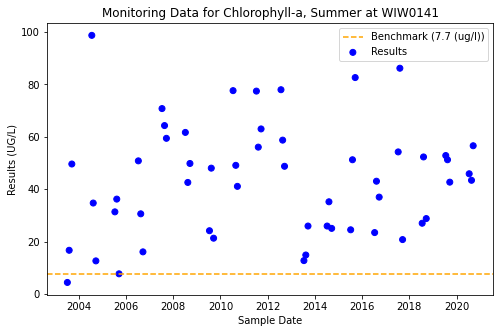

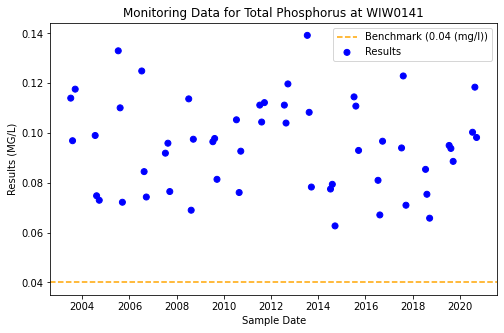

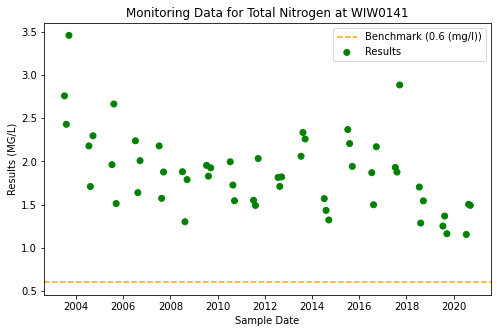

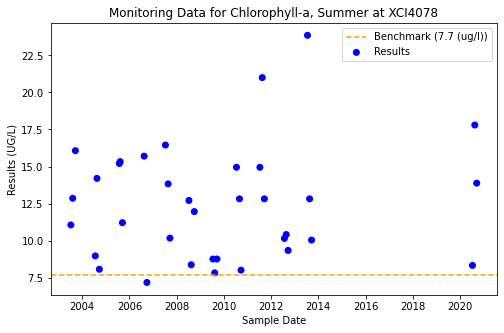

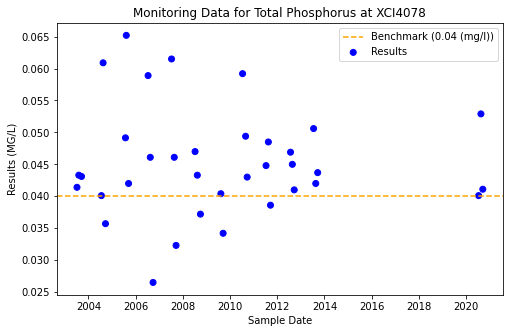

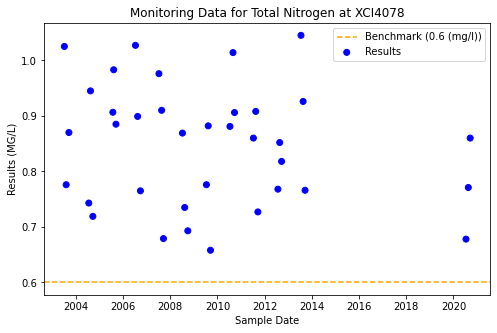

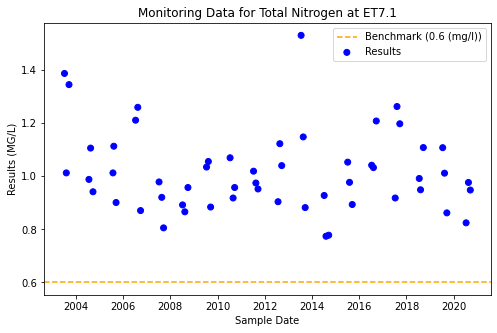

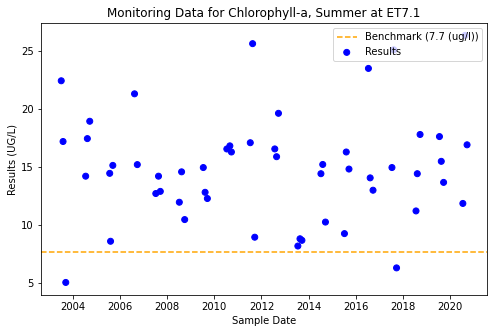

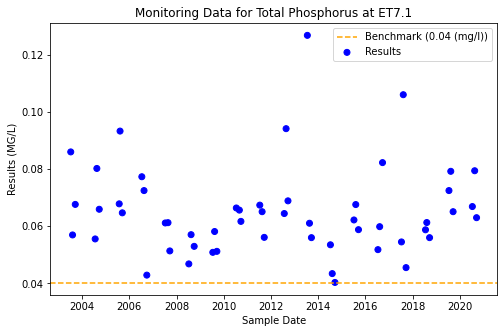

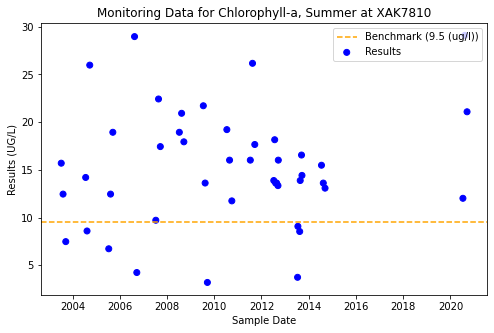

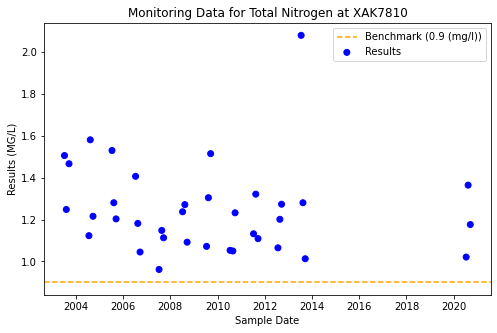

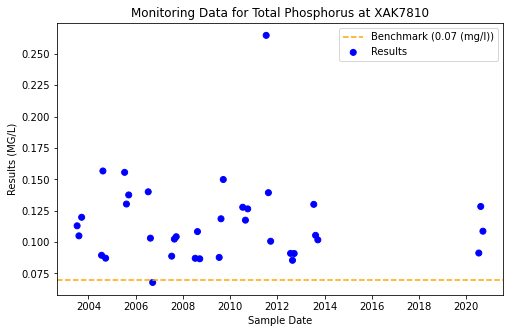

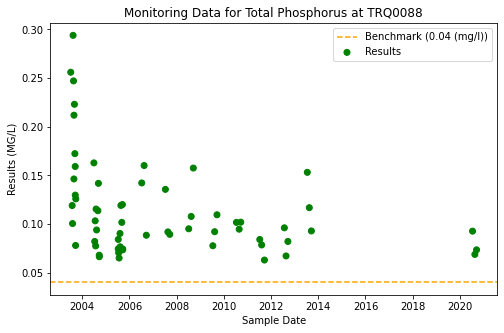

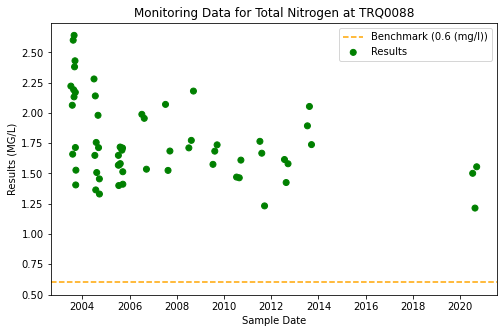

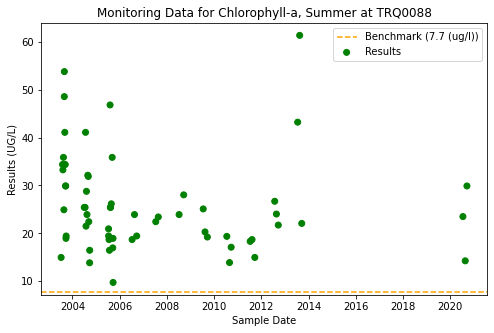

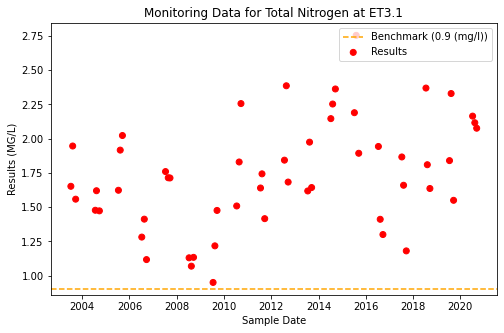

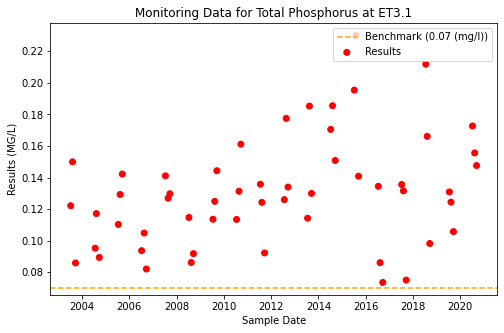

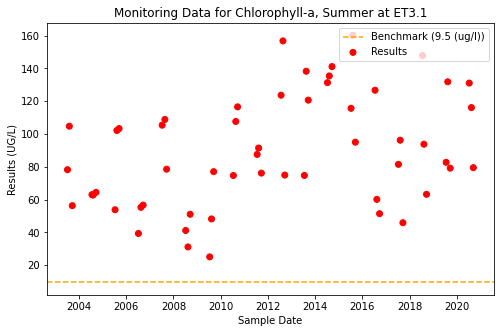

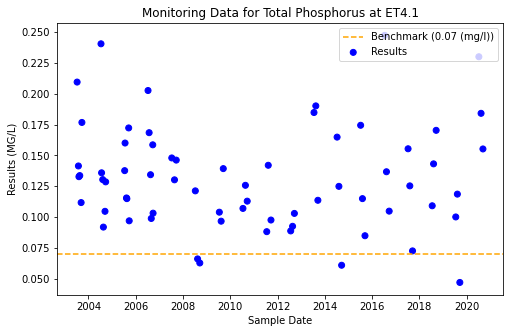

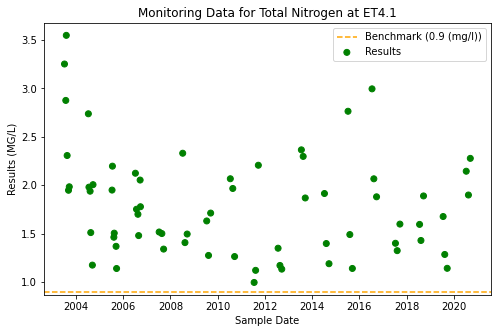

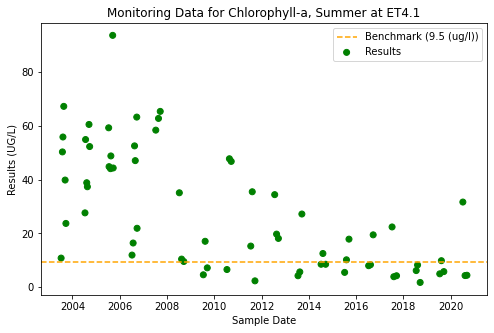

In [78]:
plots = scatters(visuals_su, stations)

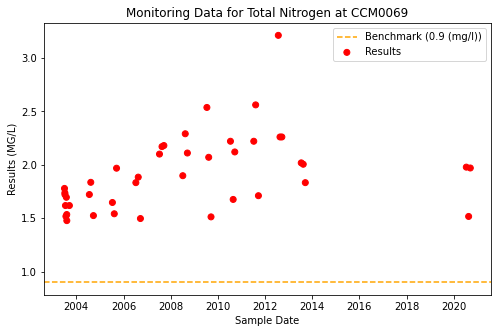

In [79]:
plots[0]

In [80]:
from matplotlib.backends.backend_pdf import PdfPages

with PdfPages('Trend Visuals_Su.pdf') as pdf:
    for fig in plots:
        pdf.savefig(fig)

### Benchmark to Three-year Average Comparison

In [81]:
#getting stations and parameters that measured all three years
years_su = final_su[final_su.Year.isin([2018, 2019, 2020])]
years_su.drop(columns=['Month', 'SampleDate', 'Unit', 'MeasureValue', 'Threshold'], inplace=True)
years_su.drop_duplicates(inplace=True)
year_count_su = years_su.groupby(['Station', 'Parameter'], as_index = False).count()
stations_3_su = year_count_su[year_count_su['Year'] == 3]
stations_3_su.rename(columns={'Year':'year_count'}, inplace=True)

#filtering down results spreadsheet to just those stations/parameters
just_3_su = pd.merge(final_su, stations_3_su, how='left', on=['Station', 'Parameter'])
just_3_su = just_3_su[(just_3_su['year_count'] == 3) & (just_3_su['Year'].isin([2018,2019,2020]))]

In [82]:
#creating three year average and comparing to threshold
average_su = just_3_su.groupby(['Station', 'Parameter','Unit', 'Threshold'], as_index=False).mean()
average_su['Three_year_Average'] = round(average_su['MeasureValue'], 2)
average_su.drop(columns = ['Year', 'Month', 'year_count', 'MeasureValue'], inplace=True)
average_su['percent_over'] = round(((average_su.Three_year_Average - average_su.Threshold)/average_su.Threshold)*100,1)

### 2020 Average compared to 2011-2013 average

In [99]:
#average by station/parameter for 2020
year_20_su = final_su[final_su['Year'] == 2020]
year_20_su.drop(columns=['Year', 'Month', 'Threshold'], inplace=True)
year_20_su['Timeframe'] = 'New'
avg_20_su = year_20_su.groupby(['Station', 'Parameter', 'Unit'], as_index=False)['MeasureValue'].agg(['mean','max','min']).round(2)
avg_20_su.reset_index(inplace=True)
avg_20_su['2020 Range'] = avg_20_su[['min','max']].apply(lambda x: '{} - {}'.format(x[0],x[1]), axis=1)
avg_20_su.drop(columns=['max','min'],inplace=True)
avg_20_su.rename(columns={'mean':'2020 Average Conc.'}, inplace=True)

#average by station/parameter for 2018-2020
year_recent_su = final_su[final_su['Year'].isin([2018,2019,2020])]
year_recent_su.drop(columns=['Year', 'Month', 'Threshold'], inplace=True)
avg_recent_su = year_recent_su.groupby(['Station', 'Parameter', 'Unit'], as_index=False)['MeasureValue'].agg(['mean','max','min']).round(2)
avg_recent_su.reset_index(inplace=True)
avg_recent_su['2018-2020 Range'] = avg_recent_su[['min','max']].apply(lambda x: '{} - {}'.format(x[0],x[1]), axis=1)
avg_recent_su.drop(columns=['max','min'],inplace=True)
avg_recent_su.rename(columns={'mean':'2018-2020 Average Conc.'}, inplace=True)

In [100]:
#average by station/parameter for 2011-2013
year_other_su = final_su[final_su['Year'].isin([2011, 2012, 2013])]
year_other_su.drop(columns=['Year', 'Month', 'Threshold'], inplace=True)
year_other_su['Timeframe'] = 'Old'
avg_other_su = year_other_su.groupby(['Station', 'Parameter', 'Unit'], as_index=False)['MeasureValue'].agg(['mean','max','min']).round(2)
avg_other_su.reset_index(inplace=True)
avg_other_su['2011-2013 Range'] = avg_other_su[['min','max']].apply(lambda x: '{} - {}'.format(x[0],x[1]), axis=1)
avg_other_su.drop(columns=['max','min'],inplace=True)
avg_other_su.rename(columns={'mean':'2011-2013 Average Conc.'}, inplace=True)

In [101]:
#dataframe for t-test
df_ttest_su = pd.concat([year_20_su, year_other_su])
df_ttest_su = df_ttest_su[df_ttest_su['Parameter'] != 'Chlorophyll-a, Spring']

t_stations_su = list(df_ttest_su.Station.unique())

In [102]:
t_df_su = t_test(df_ttest_su, t_stations_su)

In [103]:
#joining averages and comparing
new_avg_su = pd.merge(avg_20_su, avg_recent_su, how='outer', on=['Station', 'Parameter', 'Unit'])
both_avg_su = pd.merge(new_avg_su, avg_other_su, how='outer', on=['Station', 'Parameter', 'Unit'])
with_ttest_su = pd.merge(both_avg_su, t_df_su, how='outer', on=['Station', 'Parameter'])

### Writing CSVs

In [104]:
trend_final_su[['Station','Latitude','Longitude','Parameter','Trend','p-value']].to_excel("02_Trends_Su.xlsx",index=False)
average_su[['Station','Parameter','Unit','Three_year_Average','Threshold','percent_over']].to_excel('03_Benchmark Comparisons_Su.xlsx',index=False)
with_ttest_su.to_excel('04_2020 to 2011-2013 Comparison_Su.xlsx',index=False)

## Trend Analysis - All But Spring

In [105]:
#filtering data down to all but spring months
final_all = final[final['Month'].isin([1,2,7,8,9,10,11,12])]

### 2020 Average compared to 2011-2013 average

In [106]:
#average by station/parameter for 2020
year_20_all = final_all[final_all['Year'] == 2020]
year_20_all.drop(columns=['Year', 'Month', 'Threshold'], inplace=True)
year_20_all['Timeframe'] = 'New'
avg_20_all = year_20_all.groupby(['Station', 'Parameter', 'Unit'], as_index=False)['MeasureValue'].agg(['mean','max','min']).round(2)
avg_20_all.reset_index(inplace=True)
avg_20_all['2020 Range'] = avg_20_all[['min','max']].apply(lambda x: '{} - {}'.format(x[0],x[1]), axis=1)
avg_20_all.drop(columns=['max','min'],inplace=True)
avg_20_all.rename(columns={'mean':'2020 Average Conc.'}, inplace=True)

#average by station/parameter for 2018-2020
year_recent_all = final_all[final_all['Year'].isin([2018,2019,2020])]
year_recent_all.drop(columns=['Year', 'Month', 'Threshold'], inplace=True)
avg_recent_all = year_recent_all.groupby(['Station', 'Parameter', 'Unit'], as_index=False)['MeasureValue'].agg(['mean','max','min']).round(2)
avg_recent_all.reset_index(inplace=True)
avg_recent_all['2018-2020 Range'] = avg_recent_all[['min','max']].apply(lambda x: '{} - {}'.format(x[0],x[1]), axis=1)
avg_recent_all.drop(columns=['max','min'],inplace=True)
avg_recent_all.rename(columns={'mean':'2018-2020 Average Conc.'}, inplace=True)

In [107]:
#average by station/parameter for 2011-2013
year_other_all = final_all[final_all['Year'].isin([2011, 2012, 2013])]
year_other_all.drop(columns=['Year', 'Month', 'Threshold'], inplace=True)
year_other_all['Timeframe'] = 'Old'
avg_other_all = year_other_all.groupby(['Station', 'Parameter', 'Unit'], as_index=False)['MeasureValue'].agg(['mean','max','min']).round(2)
avg_other_all.reset_index(inplace=True)
avg_other_all['2011-2013 Range'] = avg_other_all[['min','max']].apply(lambda x: '{} - {}'.format(x[0],x[1]), axis=1)
avg_other_all.drop(columns=['max','min'],inplace=True)
avg_other_all.rename(columns={'mean':'2011-2013 Average Conc.'}, inplace=True)

In [108]:
#dataframe for t-test
df_ttest_all = pd.concat([year_20_all, year_other_all])
df_ttest_all = df_ttest_all[df_ttest_all['Parameter'] != 'Chlorophyll-a, Spring']

t_stations_all = list(df_ttest_all.Station.unique())

In [109]:
t_df_all = t_test(df_ttest_all, t_stations_all)

In [110]:
#joining averages and comparing
new_avg_all = pd.merge(avg_20_all, avg_recent_all, how='outer', on=['Station', 'Parameter', 'Unit'])
both_avg_all = pd.merge(new_avg_all, avg_other_all, how='outer', on=['Station', 'Parameter', 'Unit'])
with_ttest_all = pd.merge(both_avg_all, t_df_all, how='outer', on=['Station', 'Parameter'])

In [111]:
with_ttest_all.to_excel('04_2020 to 2011-2013 Comparison_All.xlsx',index=False)

Post meeting:
- Eric sent notes in email response
- look at dissolved oxygen (slower tend to have lower than fast moving rivers)
    - Water quality standard for DO
- sluggish slow moving waters, may be a bit more prone to these problems
    - characterize these waters
- look at 2010 to 2020 (when bay clean up started), use older baseline (but then mention since 2010 (no extra charts))
- explain relationship between pollutants and effect (nutrients cause chlorophyll-a to spike)
- Going to be it's own report (released on same day as Mariah's report)
- look at 03-05 rain and compare to 18-20 (is there more rain)
    - heavier rain, more runoff
- No trend = the same
- Look into whether the three samples per year/season has an effect on trends/average concentration comparisons
- Look at USGS trend analyses for nutrient trends
- check UMCES site compared to our results before release
- 